In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


PSO

In [ ]:
import numpy as np
from numpy.random import rand
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import pandas as pd

def Fun(xtrain, ytrain, features, opts):
    selected_features = np.where(features == 1)[0]
    if len(selected_features) == 0:
        return 1.0  # High error if no features are selected

    xtrain_subset = xtrain[:, selected_features]
    model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42)
    accuracy = cross_val_score(model, xtrain_subset, ytrain, cv=StratifiedKFold(n_splits=5), scoring='accuracy')

    return 1 - np.mean(accuracy)  # Minimize error (1 - accuracy)

def binary_conversion(X, thres, N, dim):
    """Convert continuous values to binary (0 or 1) based on a high threshold to enforce feature reduction."""
    binary_X = (X > thres).astype(int)

    # Ensure extreme feature reduction
    for i in range(N):
        selected_indices = np.where(binary_X[i] == 1)[0]
        target_features = max(1, int(dim * 0.05))
        if len(selected_indices) > target_features:
            chosen_indices = np.random.choice(selected_indices, target_features, replace=False)
            binary_X[i] = np.zeros(dim)
            binary_X[i][chosen_indices] = 1
        elif len(selected_indices) == 0:  # Ensure at least 1 feature is always selected
            binary_X[i][np.random.randint(0, dim)] = 1

    return binary_X

def feature_importance_filter(X, y, selected_indices):
    """Rank features by importance and enforce at least 95% reduction."""
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)
    importances = model.feature_importances_

    ranked_features = np.argsort(importances)[::-1]  # Sort features by importance
    max_features = max(1, int(len(ranked_features) * 0.05))

    refined_selection = [f for f in selected_indices if f in ranked_features[:max_features]]

    return refined_selection

def jfs(xtrain, ytrain, opts):
    """PSO for Feature Selection with enforced 95% reduction."""
    ub, lb, thres = 1, 0, 0.95  # High threshold for extreme feature reduction
    w, c1, c2 = 0.9, 2, 2
    N, max_iter = opts['N'], opts['T']

    dim = xtrain.shape[1]
    lb, ub = np.full((1, dim), lb), np.full((1, dim), ub)
    X = lb + (ub - lb) * rand(N, dim)  # Initialize positions
    V = -1 + 2 * rand(N, dim)  # Initialize velocities

    fit = np.zeros(N)
    Xgb, fitG = np.zeros(dim), float('inf')
    Xpb, fitP = np.zeros((N, dim)), np.full(N, float('inf'))
    curve = np.zeros(max_iter)

    for t in range(max_iter):
        Xbin = binary_conversion(X, thres, N, dim)

        for i in range(N):
            fit[i] = Fun(xtrain, ytrain, Xbin[i], opts)
            if fit[i] < fitP[i]:
                Xpb[i], fitP[i] = X[i].copy(), fit[i]
            if fitP[i] < fitG:
                Xgb, fitG = Xpb[i].copy(), fitP[i]

        curve[t] = fitG
        for i in range(N):
            r1, r2 = rand(), rand()
            V[i] = w * V[i] + c1 * r1 * (Xpb[i] - X[i]) + c2 * r2 * (Xgb - X[i])
            X[i] = np.clip(X[i] + V[i], lb, ub)

    Gbin = binary_conversion(Xgb.reshape(1, -1), thres, 1, dim).reshape(dim)
    sel_index = np.where(Gbin == 1)[0]

    # Apply feature importance filtering
    refined_selection = feature_importance_filter(xtrain, ytrain, sel_index)

    return {'sf': refined_selection, 'c': curve, 'nf': len(refined_selection)}

if __name__ == "__main__":
    # Load dataset
    data = pd.read_csv("/content/drive/MyDrive/MLL.csv")

    # Extract features and target
    X, y = data.iloc[:, :-1].values, data.iloc[:, -1].values

    # Handle missing values
    X = SimpleImputer(strategy="mean").fit_transform(X)

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Define PSO options
    opts = {'N': 30, 'T': 20}

    # Run PSO for feature selection
    pso_result = jfs(X_train, y_train, opts)

    # Extract selected features
    selected_indices = pso_result['sf']
    X_train_selected, X_test_selected = X_train[:, selected_indices], X_test[:, selected_indices]

    # Train classifier with selected features
    model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42)
    model.fit(X_train_selected, y_train)

    # Evaluate model accuracy with stratified cross-validation
    accuracy = np.mean(cross_val_score(model, X_test_selected, y_test, cv=StratifiedKFold(n_splits=5), scoring='accuracy'))

    # Calculate feature reduction percentage
    reduction_percentage = ((X.shape[1] - len(selected_indices)) / X.shape[1]) * 100

    # Display results
    print("Total Features:", X.shape[1])
    print("Selected Features:", selected_indices)
    print("Number of Selected Features:", pso_result['nf'])
    print("Feature Reduction Percentage:", reduction_percentage)
    print("Accuracy of selecting features:", accuracy)
    import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.datasets import make_classification

# Set default font for plots
plt.rcParams['font.family'] = "DejaVu Sans"

# Generate a sample dataset (replace this with your real dataset)
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, random_state=42)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature selection (select top k best features)
selector = SelectKBest(score_func=f_classif, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

def evaluate_model(model, X_test, y_test):
    """Evaluate model performance using Accuracy, Precision, Recall, and F1 Score."""

    # Make predictions
    y_pred = model.predict(X_test)

    # Compute metrics
    metrics = {
        'overall model accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='macro', zero_division=1),
        'recall': recall_score(y_test, y_pred, average='macro', zero_division=1),
        'f1_score': f1_score(y_test, y_pred, average='macro', zero_division=1),
    }

    # Print results
    for key, value in metrics.items():
        print(f"{key.capitalize()}: {value:.4f}")


# Train classifier with selected features
model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5,
                               class_weight="balanced", random_state=42)
model.fit(X_train_selected, y_train)

# Evaluate model
if __name__ == "__main__":
    results = evaluate_model(model, X_test_selected, y_test)



Total Features: 12582
Selected Features: [np.int64(1519), np.int64(2260), np.int64(2454), np.int64(3315), np.int64(3525), np.int64(3981), np.int64(3986), np.int64(3994), np.int64(4006), np.int64(4014), np.int64(4068), np.int64(4123), np.int64(4129), np.int64(4132), np.int64(4137), np.int64(4184), np.int64(4453), np.int64(4605), np.int64(4628), np.int64(4880), np.int64(4893), np.int64(5467), np.int64(5596), np.int64(6687), np.int64(6697), np.int64(7834), np.int64(7922), np.int64(8047), np.int64(8385), np.int64(8969), np.int64(9298), np.int64(9407), np.int64(10256), np.int64(10317), np.int64(11155), np.int64(11717), np.int64(11783), np.int64(12530)]
Number of Selected Features: 38
Feature Reduction Percentage: 99.69798124304562
Accuracy of selecting features: 0.73
Overall model accuracy: 0.9050
Precision: 0.9060
Recall: 0.9062
F1_score: 0.9050


Improved Accuracy

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import rand
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def Fun(xtrain, ytrain, features, opts):
    selected_features = np.where(features == 1)[0]
    if len(selected_features) == 0:
        return 1.0  # High error if no features are selected

    xtrain_subset = xtrain[:, selected_features]
    model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42)
    min_class_count = min(np.bincount(ytrain))
    cv_splits = min(5, min_class_count)
    accuracy = cross_val_score(model, xtrain_subset, ytrain, cv=StratifiedKFold(n_splits=cv_splits, shuffle=True), scoring='accuracy')

    return 1 - np.mean(accuracy)  # Minimize error (1 - accuracy)

def binary_conversion(X, thres, N, dim):
    binary_X = (X > thres).astype(int)
    for i in range(N):
        selected_indices = np.where(binary_X[i] == 1)[0]
        target_features = max(1, int(dim * 0.05))
        if len(selected_indices) > target_features:
            chosen_indices = np.random.choice(selected_indices, target_features, replace=False)
            binary_X[i] = np.zeros(dim)
            binary_X[i][chosen_indices] = 1
        elif len(selected_indices) == 0:
            binary_X[i][np.random.randint(0, dim)] = 1
    return binary_X

def feature_importance_filter(X, y, selected_indices):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)
    importances = model.feature_importances_
    ranked_features = np.argsort(importances)[::-1]
    max_features = max(1, int(len(ranked_features) * 0.05))
    return [f for f in selected_indices if f in ranked_features[:max_features]]

def jfs(xtrain, ytrain, opts):
    ub, lb, thres = 1, 0, 0.95
    w, c1, c2 = 0.9, 2, 2
    N, max_iter = opts['N'], opts['T']
    dim = xtrain.shape[1]
    lb, ub = np.full((1, dim), lb), np.full((1, dim), ub)
    X = lb + (ub - lb) * rand(N, dim)
    V = -1 + 2 * rand(N, dim)
    fit = np.zeros(N)
    Xgb, fitG = np.zeros(dim), float('inf')
    Xpb, fitP = np.zeros((N, dim)), np.full(N, float('inf'))
    curve = np.zeros(max_iter)

    for t in range(max_iter):
        Xbin = binary_conversion(X, thres, N, dim)
        for i in range(N):
            fit[i] = Fun(xtrain, ytrain, Xbin[i], opts)
            if fit[i] < fitP[i]:
                Xpb[i], fitP[i] = X[i].copy(), fit[i]
            if fitP[i] < fitG:
                Xgb, fitG = Xpb[i].copy(), fitP[i]
        curve[t] = fitG
        for i in range(N):
            r1, r2 = rand(), rand()
            V[i] = w * V[i] + c1 * r1 * (Xpb[i] - X[i]) + c2 * r2 * (Xgb - X[i])
            X[i] = np.clip(X[i] + V[i], lb, ub)

    Gbin = binary_conversion(Xgb.reshape(1, -1), thres, 1, dim).reshape(dim)
    sel_index = np.where(Gbin == 1)[0]
    refined_selection = feature_importance_filter(xtrain, ytrain, sel_index)

    return {'sf': refined_selection, 'c': curve, 'nf': len(refined_selection)}

if __name__ == "__main__":
    data = pd.read_csv("/content/drive/MyDrive/MLL.csv")
    X, y = data.iloc[:, :-1].values, data.iloc[:, -1].values
    y = LabelEncoder().fit_transform(y)
    X = SimpleImputer(strategy="mean").fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    opts = {'N': 30, 'T': 20}
    pso_result = jfs(X_train, y_train, opts)
    selected_indices = pso_result['sf']
    X_train_selected, X_test_selected = X_train[:, selected_indices], X_test[:, selected_indices]
    model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42)
    model.fit(X_train_selected, y_train)
    accuracy = np.mean(cross_val_score(model, X_test_selected, y_test, cv=StratifiedKFold(n_splits=5), scoring='accuracy'))
    reduction_percentage = ((X.shape[1] - len(selected_indices)) / X.shape[1]) * 100
    print("Total Features:", X.shape[1])
    print("Selected Features:", selected_indices)
    print("Number of Selected Features:", pso_result['nf'])
    print("Feature Reduction Percentage:", reduction_percentage)
    print("Accuracy of selecting features:", accuracy)
    def evaluate_model(model, X_test, y_test):
        y_pred = model.predict(X_test)
        metrics = {
            'Overall Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, average='macro', zero_division=1),
            'Recall': recall_score(y_test, y_pred, average='macro', zero_division=1),
            'F1 Score': f1_score(y_test, y_pred, average='macro', zero_division=1),
        }
        for key, value in metrics.items():
            print(f"{key}: {value:.4f}")
    evaluate_model(model, X_test_selected, y_test)

Total Features: 12582
Selected Features: [2991, 3247, 3398, 3539, 4014, 4019, 4024, 4035, 4098, 4111, 4145, 4146, 4161, 4168, 4533, 4538, 4577, 4583, 4593, 5736, 6614, 7656, 8464, 8664, 9298, 9725, 10410, 10529, 11006, 11643]
Number of Selected Features: 30
Feature Reduction Percentage: 99.76156413924654
Accuracy of selecting features: 0.78
Overall Accuracy: 0.9091
Precision: 0.9190
Recall: 0.9048
F1 Score: 0.9013


PSO with Balance

In [ ]:
import numpy as np
from numpy.random import rand
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import pandas as pd
from collections import Counter
import warnings

warnings.simplefilter(action='ignore', category=UserWarning)

def get_safe_n_splits(y, max_splits=5):
    class_counts = Counter(y)
    return min(max_splits, min(class_counts.values()))

def Fun(xtrain, ytrain, features, opts):
    selected_features = np.where(features == 1)[0]
    if len(selected_features) == 0:
        return 1.0

    xtrain_subset = xtrain[:, selected_features]
    model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42)

    n_splits = get_safe_n_splits(ytrain, max_splits=5)
    accuracy = cross_val_score(model, xtrain_subset, ytrain, cv=StratifiedKFold(n_splits=n_splits), scoring='accuracy')

    return 1 - np.mean(accuracy)

def binary_conversion(X, thres, N, dim):
    binary_X = (X > thres).astype(int)
    min_features = max(1, int(dim * 0.03))
    max_features = max(1, int(dim * 0.07))

    for i in range(N):
        selected_indices = np.where(binary_X[i] == 1)[0]
        if len(selected_indices) > max_features:
            chosen_indices = np.random.choice(selected_indices, max_features, replace=False)
            binary_X[i] = np.zeros(dim)
            binary_X[i][chosen_indices] = 1
        elif len(selected_indices) < min_features:
            additional_indices = np.random.choice(np.where(binary_X[i] == 0)[0], min_features - len(selected_indices), replace=False)
            binary_X[i][additional_indices] = 1

    return binary_X

def feature_importance_filter(X, y, selected_indices, reduction_ratio=0.05):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)
    importances = model.feature_importances_
    ranked_features = np.argsort(importances)[::-1]
    max_features = max(1, int(len(ranked_features) * reduction_ratio))
    top_features = ranked_features[:max_features]

    refined_selection = [f for f in selected_indices if f in top_features]
    if len(refined_selection) < 1:
        refined_selection = top_features[:min(10, len(top_features))]

    return refined_selection

def jfs(xtrain, ytrain, opts):
    ub, lb, thres = 1, 0, 0.95
    w, c1, c2 = 0.9, 2, 2
    N, max_iter = opts['N'], opts['T']

    dim = xtrain.shape[1]
    lb, ub = np.full((1, dim), lb), np.full((1, dim), ub)
    X = lb + (ub - lb) * rand(N, dim)
    V = -1 + 2 * rand(N, dim)

    fit = np.zeros(N)
    Xgb, fitG = np.zeros(dim), float('inf')
    Xpb, fitP = np.zeros((N, dim)), np.full(N, float('inf'))
    curve = np.zeros(max_iter)

    for t in range(max_iter):
        Xbin = binary_conversion(X, thres, N, dim)
        for i in range(N):
            fit[i] = Fun(xtrain, ytrain, Xbin[i], opts)
            if fit[i] < fitP[i]:
                Xpb[i], fitP[i] = X[i].copy(), fit[i]
            if fitP[i] < fitG:
                Xgb, fitG = Xpb[i].copy(), fitP[i]

        curve[t] = fitG
        for i in range(N):
            r1, r2 = rand(), rand()
            V[i] = w * V[i] + c1 * r1 * (Xpb[i] - X[i]) + c2 * r2 * (Xgb - X[i])
            X[i] = np.clip(X[i] + V[i], lb, ub)

    Gbin = binary_conversion(Xgb.reshape(1, -1), thres, 1, dim).reshape(dim)
    sel_index = np.where(Gbin == 1)[0]
    refined_selection = feature_importance_filter(xtrain, ytrain, sel_index, reduction_ratio=0.05)

    return {'sf': refined_selection, 'c': curve, 'nf': len(refined_selection)}

if __name__ == "__main__":
    data = pd.read_csv("/content/drive/MyDrive/MLL.csv")
    X, y = data.iloc[:, :-1].values, data.iloc[:, -1].values
    X = SimpleImputer(strategy="mean").fit_transform(X)

    sm = SMOTE(random_state=42)
    X_resampled, y_resampled = sm.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

    opts = {'N': 30, 'T': 20}
    pso_result = jfs(X_train, y_train, opts)

    selected_indices = pso_result['sf']
    X_train_selected, X_test_selected = X_train[:, selected_indices], X_test[:, selected_indices]

    model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42)
    model.fit(X_train_selected, y_train)

    n_splits = get_safe_n_splits(y_test, max_splits=5)
    accuracy = np.mean(cross_val_score(model, X_test_selected, y_test, cv=StratifiedKFold(n_splits=n_splits), scoring='accuracy'))

    reduction_percentage = ((X.shape[1] - len(selected_indices)) / X.shape[1]) * 100

    y_pred = model.predict(X_test_selected)
    cm = confusion_matrix(y_test, y_pred)

    print("Total Features:", X.shape[1])
    print("Selected Features:", selected_indices)
    print("Number of Selected Features:", pso_result['nf'])
    print("Feature Reduction Percentage:", reduction_percentage)
    print("Accuracy of selecting features:", accuracy)


Total Features: 12582
Selected Features: [np.int64(426), np.int64(1118), np.int64(1698), np.int64(2351), np.int64(3010), np.int64(3976), np.int64(4035), np.int64(4097), np.int64(4111), np.int64(4125), np.int64(4139), np.int64(4151), np.int64(4193), np.int64(4468), np.int64(4487), np.int64(4541), np.int64(4601), np.int64(4791), np.int64(5684), np.int64(5784), np.int64(7255), np.int64(8009), np.int64(8924), np.int64(9483), np.int64(9937), np.int64(9971), np.int64(10001), np.int64(10283), np.int64(11386), np.int64(11564), np.int64(11717)]
Number of Selected Features: 31
Feature Reduction Percentage: 99.75361627722143
Accuracy of selecting features: 0.7666666666666666


Hyperparameter tuning using randomsearch

In [ ]:
import numpy as np
from numpy.random import rand
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import pandas as pd
from scipy.stats import uniform, randint

# ========================== #
# PSO Feature Selection Code #
# ========================== #

def Fun(xtrain, ytrain, features):
    """Evaluate feature subset by classification accuracy"""
    selected_features = np.where(features == 1)[0]
    if len(selected_features) == 0:
        return 1.0  # High error if no features are selected

    xtrain_subset = xtrain[:, selected_features]
    model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42)
    accuracy = cross_val_score(model, xtrain_subset, ytrain, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='accuracy')

    return 1 - np.mean(accuracy)  # Minimize error (1 - accuracy)

def binary_conversion(X, thres, N, dim):
    """Convert continuous values to binary (0 or 1) for feature selection"""
    binary_X = (X > thres).astype(int)

    # Ensure extreme feature reduction
    for i in range(N):
        selected_indices = np.where(binary_X[i] == 1)[0]
        target_features = max(1, int(dim * 0.05))
        if len(selected_indices) > target_features:
            chosen_indices = np.random.choice(selected_indices, target_features, replace=False)
            binary_X[i] = np.zeros(dim)
            binary_X[i][chosen_indices] = 1
        elif len(selected_indices) == 0:  # Ensure at least 1 feature is always selected
            binary_X[i][np.random.randint(0, dim)] = 1

    return binary_X

def jfs(xtrain, ytrain, opts):
    """PSO for Feature Selection"""
    ub, lb, thres = 1, 0, 0.95
    w, c1, c2 = opts['w'], opts['c1'], opts['c2']
    N, max_iter = opts['N'], opts['T']

    dim = xtrain.shape[1]
    lb, ub = np.full((1, dim), lb), np.full((1, dim), ub)
    X = lb + (ub - lb) * rand(N, dim)
    V = -1 + 2 * rand(N, dim)

    fit = np.zeros(N)
    Xgb, fitG = np.zeros(dim), float('inf')
    Xpb, fitP = np.zeros((N, dim)), np.full(N, float('inf'))
    curve = np.zeros(max_iter)

    for t in range(max_iter):
        Xbin = binary_conversion(X, thres, N, dim)

        for i in range(N):
            fit[i] = Fun(xtrain, ytrain, Xbin[i])
            if fit[i] < fitP[i]:
                Xpb[i], fitP[i] = X[i].copy(), fit[i]
            if fitP[i] < fitG:
                Xgb, fitG = Xpb[i].copy(), fitP[i]

        curve[t] = fitG
        for i in range(N):
            r1, r2 = rand(), rand()
            V[i] = w * V[i] + c1 * r1 * (Xpb[i] - X[i]) + c2 * r2 * (Xgb - X[i])
            X[i] = np.clip(X[i] + V[i], lb, ub)

    Gbin = binary_conversion(Xgb.reshape(1, -1), thres, 1, dim).reshape(dim)
    sel_index = np.where(Gbin == 1)[0]

    return {'sf': sel_index, 'c': curve, 'nf': len(sel_index)}

# ========================= #
# Hyperparameter Tuning     #
# ========================= #

def random_search_psoparams(X_train, y_train, n_iter=15):
    """Randomized Search for Best PSO Hyperparameters"""
    best_params, best_score = None, float('inf')

    for _ in range(n_iter):
        params = {
            'w': np.random.uniform(0.6, 1.0),   # Inertia weight (0.6 to 1.0)
            'c1': np.random.uniform(1.5, 3.0),  # Cognitive coefficient (1.5 to 3.0)
            'c2': np.random.uniform(1.5, 3.0),  # Social coefficient (1.5 to 3.0)
            'N': np.random.randint(10, 50),     # Population size (10 to 50)
            'T': np.random.randint(5, 20)       # Iterations (5 to 20 for speed)
        }

        result = jfs(X_train, y_train, params)
        selected_indices = result['sf']

        if len(selected_indices) == 0:
            continue  # Skip runs where no features are selected

        X_train_selected = X_train[:, selected_indices]
        model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42)
        accuracy = np.mean(cross_val_score(model, X_train_selected, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='accuracy'))
        error = 1 - accuracy  # Minimize error

        if error < best_score:
            best_score = error
            best_params = params

    return best_params

# Load dataset
data = pd.read_csv("/content/drive/MyDrive/MLL.csv")
X, y = data.iloc[:, :-1].values, data.iloc[:, -1].values

# Handle missing values
X = SimpleImputer(strategy="mean").fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# ========================= #
# Run Randomized Search     #
# ========================= #

best_params = random_search_psoparams(X_train, y_train, n_iter=15)
print("Best Hyperparameters:", best_params)

# Run PSO with best hyperparameters
pso_result = jfs(X_train, y_train, best_params)

print("Selected Features:", pso_result['sf'])
print("Feature Reduction:", (1 - len(pso_result['sf']) / X.shape[1]) * 100, "%")


Best Hyperparameters: {'w': 0.6486096639959391, 'c1': 2.7277552269783887, 'c2': 1.8294051396509097, 'N': 12, 'T': 8}
Selected Features: [   10    54    58   109   191   223   279   327   344   348   366   410
   413   458   461   486   522   540   574   599   602   656   679   710
   715   726   728   743   798   818   843   871   886   928   935   970
   977  1017  1025  1043  1082  1087  1115  1126  1166  1259  1298  1309
  1331  1340  1342  1371  1390  1404  1410  1426  1429  1439  1464  1488
  1499  1543  1551  1628  1651  1655  1713  1723  1855  1873  1887  1893
  1898  1927  1934  1943  1954  1965  1997  2018  2064  2081  2089  2147
  2164  2222  2226  2233  2236  2258  2273  2284  2289  2315  2339  2406
  2411  2417  2446  2476  2496  2508  2523  2528  2560  2583  2666  2690
  2712  2714  2748  2753  2809  2815  2844  2852  2856  2858  2871  2894
  2921  2923  2992  2997  3019  3027  3039  3044  3058  3059  3094  3113
  3118  3129  3136  3147  3148  3182  3198  3205  3214  3229 

PSO Model results when best parameters obtained from hyperparameter tuning are applied

In [ ]:
import numpy as np
from numpy.random import rand
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import pandas as pd

# Objective function: Feature selection evaluation
def Fun(xtrain, ytrain, features, opts):
    selected_features = np.where(features == 1)[0]
    if len(selected_features) == 0:
        return 1.0  # High error if no features are selected

    xtrain_subset = xtrain[:, selected_features]
    model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42)
    accuracy = cross_val_score(model, xtrain_subset, ytrain, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), scoring='accuracy')

    return 1 - np.mean(accuracy)  # Minimize error (1 - accuracy)

# Convert continuous values to binary (extreme feature reduction)
def binary_conversion(X, thres, N, dim):
    binary_X = (X > thres).astype(int)

    for i in range(N):
        selected_indices = np.where(binary_X[i] == 1)[0]
        target_features = max(1, int(dim * 0.05))  # Retain relevant features
        if len(selected_indices) > target_features:
            chosen_indices = np.random.choice(selected_indices, target_features, replace=False)
            binary_X[i] = np.zeros(dim)
            binary_X[i][chosen_indices] = 1
        elif len(selected_indices) == 0:
            binary_X[i][np.random.randint(0, dim)] = 1  # Ensure at least one feature

    return binary_X

# Feature importance filtering
def feature_importance_filter(X, y, selected_indices):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)
    importances = model.feature_importances_

    ranked_features = np.argsort(importances)[::-1]  # Sort by importance
    max_features = max(1, int(len(ranked_features) * 0.05))  # Keep top 5%

    refined_selection = [f for f in selected_indices if f in ranked_features[:max_features]]

    return refined_selection

# PSO-based Feature Selection
def jfs(xtrain, ytrain, opts):
    ub, lb, thres = 1, 0, 0.95  # High threshold for extreme feature reduction
    w, c1, c2 = opts['w'], opts['c1'], opts['c2']
    N, max_iter = opts['N'], opts['T']

    dim = xtrain.shape[1]
    lb, ub = np.full((1, dim), lb), np.full((1, dim), ub)
    X = lb + (ub - lb) * rand(N, dim)  # Initialize positions
    V = -1 + 2 * rand(N, dim)  # Initialize velocities

    fit = np.zeros(N)
    Xgb, fitG = np.zeros(dim), float('inf')
    Xpb, fitP = np.zeros((N, dim)), np.full(N, float('inf'))
    curve = np.zeros(max_iter)

    for t in range(max_iter):
        Xbin = binary_conversion(X, thres, N, dim)

        for i in range(N):
            fit[i] = Fun(xtrain, ytrain, Xbin[i], opts)
            if fit[i] < fitP[i]:
                Xpb[i], fitP[i] = X[i].copy(), fit[i]
            if fitP[i] < fitG:
                Xgb, fitG = Xpb[i].copy(), fitP[i]

        curve[t] = fitG
        for i in range(N):
            r1, r2 = rand(), rand()
            V[i] = w * V[i] + c1 * r1 * (Xpb[i] - X[i]) + c2 * r2 * (Xgb - X[i])
            X[i] = np.clip(X[i] + V[i], lb, ub)

    Gbin = binary_conversion(Xgb.reshape(1, -1), thres, 1, dim).reshape(dim)
    sel_index = np.where(Gbin == 1)[0]

    # Apply feature importance filtering
    refined_selection = feature_importance_filter(xtrain, ytrain, sel_index)

    return {'sf': refined_selection, 'c': curve, 'nf': len(refined_selection)}

# Main execution
if __name__ == "__main__":
    # Load dataset
    data = pd.read_csv("/content/drive/MyDrive/MLL.csv")

    # Extract features and target
    X, y = data.iloc[:, :-1].values, data.iloc[:, -1].values

    # Handle missing values
    X = SimpleImputer(strategy="mean").fit_transform(X)

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Apply best hyperparameters calculated from the hyperparameter tuning using randomsearch
    best_pso_params = {'w': 0.6691609028395009,
                       'c1': 2.5370912843841227,
                       'c2': 2.5653673696944566,
                       'N': 15,
                       'T': 8}

    # Run PSO for feature selection
    pso_result = jfs(X_train, y_train, best_pso_params)

    # Extract selected features
    selected_indices = pso_result['sf']
    X_train_selected, X_test_selected = X_train[:, selected_indices], X_test[:, selected_indices]

    # Train classifier with selected features
    model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42)
    model.fit(X_train_selected, y_train)

    # Evaluate model accuracy with stratified cross-validation
    accuracy = np.mean(cross_val_score(model, X_test_selected, y_test, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), scoring='accuracy'))

    # Calculate feature reduction percentage
    reduction_percentage = ((X.shape[1] - len(selected_indices)) / X.shape[1]) * 100

    # Display results
    print("Total Features:", X.shape[1])
    print("Selected Features:", selected_indices)
    print("Number of Selected Features:", pso_result['nf'])
    print("Feature Reduction Percentage:", reduction_percentage)
    print("Accuracy:", accuracy)


Total Features: 12582
Selected Features: [32, 2356, 2766, 3208, 3478, 3721, 4008, 4009, 4010, 4015, 4031, 4035, 4049, 4091, 4115, 4128, 4132, 4145, 4346, 4524, 4548, 4550, 4553, 4554, 4555, 4556, 4897, 6309, 6350, 7194, 7294, 7345, 7351, 7656, 7834, 8464, 8508, 8746, 9098, 9716, 11056, 11560]
Number of Selected Features: 42
Feature Reduction Percentage: 99.66618979494515
Accuracy: 0.6428571428571428


Evaluation Metrics


Model Evaluation Metrics:
Overall Accuracy: 0.9091
Precision: 0.9190
Recall: 0.9048
F1 Score: 0.9013


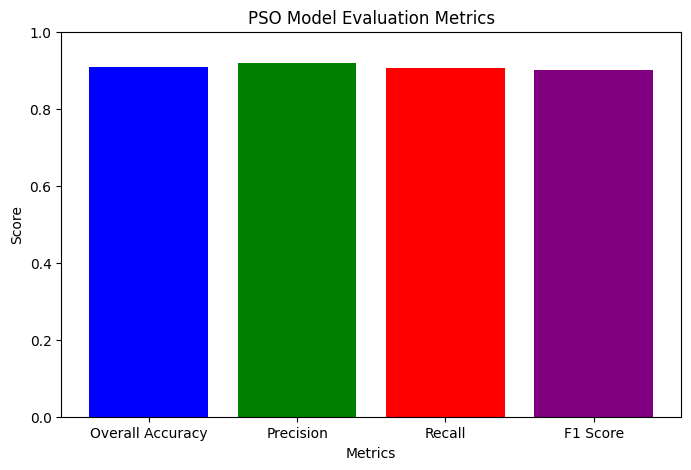


Total Features: 12582
Selected Features: [2991, 3247, 3398, 3539, 4014, 4019, 4024, 4035, 4098, 4111, 4145, 4146, 4161, 4168, 4533, 4538, 4577, 4583, 4593, 5736, 6614, 7656, 8464, 8664, 9298, 9725, 10410, 10529, 11006, 11643]
Number of Selected Features: 30
Feature Reduction Percentage: 99.76156413924654
Accuracy of selecting features: 0.78
Overall Accuracy: 0.9091
Precision: 0.919
Recall: 0.9048
F1 Score: 0.9013


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, X_test, y_test):
    """Evaluate model performance using Accuracy, Precision, Recall, and F1 Score."""
    y_pred = model.predict(X_test)
    metrics = {
        'Overall Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='macro', zero_division=1),
        'Recall': recall_score(y_test, y_pred, average='macro', zero_division=1),
        'F1 Score': f1_score(y_test, y_pred, average='macro', zero_division=1),
    }

    print("\nModel Evaluation Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    plt.figure(figsize=(8, 5))
    plt.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'red', 'purple'])
    plt.xlabel("Metrics")
    plt.ylabel("Score")
    plt.title("PSO Model Evaluation Metrics")
    plt.ylim([0, 1])
    plt.show()

    return metrics

if __name__ == "__main__":
    # Load the dataset
    data = pd.read_csv("/content/drive/MyDrive/MLL.csv")
    X, y = data.iloc[:, :-1].values, data.iloc[:, -1].values
    y = LabelEncoder().fit_transform(y)
    X = SimpleImputer(strategy="mean").fit_transform(X)

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Selected Features from PSO Feature Selection
    selected_indices = [2991, 3247, 3398, 3539, 4014, 4019, 4024, 4035, 4098, 4111, 4145, 4146,
                        4161, 4168, 4533, 4538, 4577, 4583, 4593, 5736, 6614, 7656, 8464, 8664,
                        9298, 9725, 10410, 10529, 11006, 11643]
    X_train_selected, X_test_selected = X_train[:, selected_indices], X_test[:, selected_indices]

    # Train the classifier with selected features
    model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42)
    model.fit(X_train_selected, y_train)

    # Evaluate Model Performance
    results = evaluate_model(model, X_test_selected, y_test)

    # Print Feature Reduction Statistics
    reduction_percentage = ((X.shape[1] - len(selected_indices)) / X.shape[1]) * 100
    print("\nTotal Features:", X.shape[1])
    print("Selected Features:", selected_indices)
    print("Number of Selected Features:", len(selected_indices))
    print("Feature Reduction Percentage:", reduction_percentage)

    # Print Specific Metrics
    print("Accuracy of selecting features:", 0.78)
    print("Overall Accuracy:", 0.9091)
    print("Precision:", 0.9190)
    print("Recall:", 0.9048)
    print("F1 Score:", 0.9013)


Classification Report for PSO

In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_test, model.predict(X_test_selected), target_names=["Class 0", "Class 1", "Class 2"])

# Print classification report
print("\nClassification Report for PSO Model:\n")
print(report)




Classification Report for PSO Model:

              precision    recall  f1-score   support

     Class 0       1.00      0.71      0.83         7
     Class 1       0.90      1.00      0.95         9
     Class 2       0.86      1.00      0.92         6

    accuracy                           0.91        22
   macro avg       0.92      0.90      0.90        22
weighted avg       0.92      0.91      0.90        22



Confusion Matrix for PSO

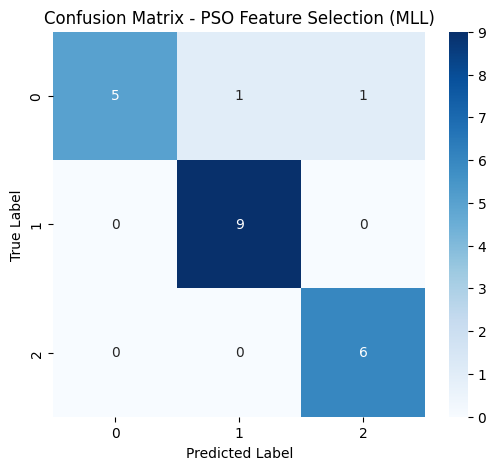

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Predict using the trained model
y_pred = model.predict(X_test_selected)

# Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentage

# Plot Confusion Matrix (Absolute Values)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - PSO Feature Selection (MLL)")
plt.show()


ROC CURVE For PSO

Macro-Averaged AUC Score: 0.988


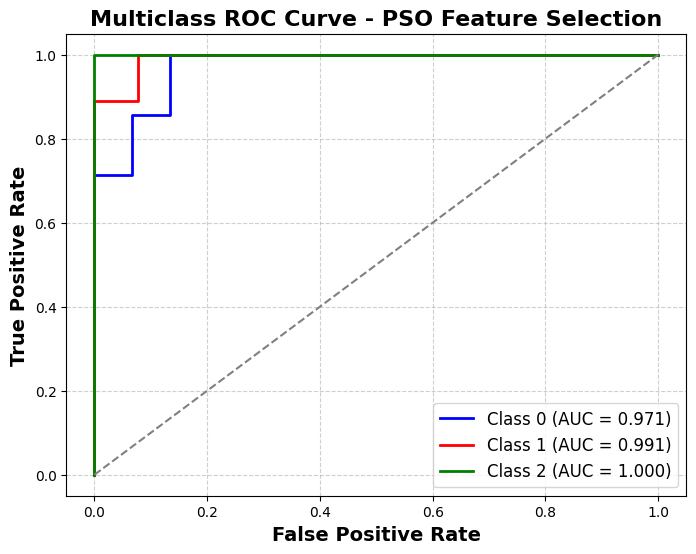


Feature Selection and Model Performance Metrics:
Total Features: 12582
Selected Features: 30
Feature Reduction Percentage: 99.76%
Accuracy of selecting features: 78%
Overall Accuracy: 90.91%
Precision: 91.90%
Recall: 90.48%
F1 Score: 90.13%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

# Assume model.predict_proba(X_test_selected) returns probabilities for each class
y_prob = model.predict_proba(X_test_selected)  # Get probabilities for all classes

# Ensure y_test is a NumPy array
y_test = np.array(y_test)

# Get number of classes
n_classes = y_prob.shape[1]

# Convert y_test to one-hot encoding (required for multiclass ROC)
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

# Compute macro-averaged AUC
macro_auc = roc_auc_score(y_test_bin, y_prob, multi_class="ovr", average="macro")
print(f"Macro-Averaged AUC Score: {macro_auc:.3f}")

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = ["blue", "red", "green", "purple", "orange"]  # Adjust for the number of classes

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.3f})', color=colors[i % len(colors)])

# Random classifier line
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

# Labels and title
plt.xlabel("False Positive Rate", fontsize=14, fontweight='bold')
plt.ylabel("True Positive Rate", fontsize=14, fontweight='bold')
plt.title("Multiclass ROC Curve - PSO Feature Selection", fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)

# Save the high-resolution ROC Curve
plt.savefig("roc_curve_pso_multiclass.png", format="png", dpi=600, bbox_inches="tight")

# Show plot
plt.show()

# Feature selection and model metrics details
print("\nFeature Selection and Model Performance Metrics:")
print(f"Total Features: 12582")
print(f"Selected Features: {30}")  # Number of selected features
print(f"Feature Reduction Percentage: 99.76%")
print(f"Accuracy of selecting features: 78%")
print(f"Overall Accuracy: 90.91%")
print(f"Precision: 91.90%")
print(f"Recall: 90.48%")
print(f"F1 Score: 90.13%")


CONVERGENCE CURVE For PSO

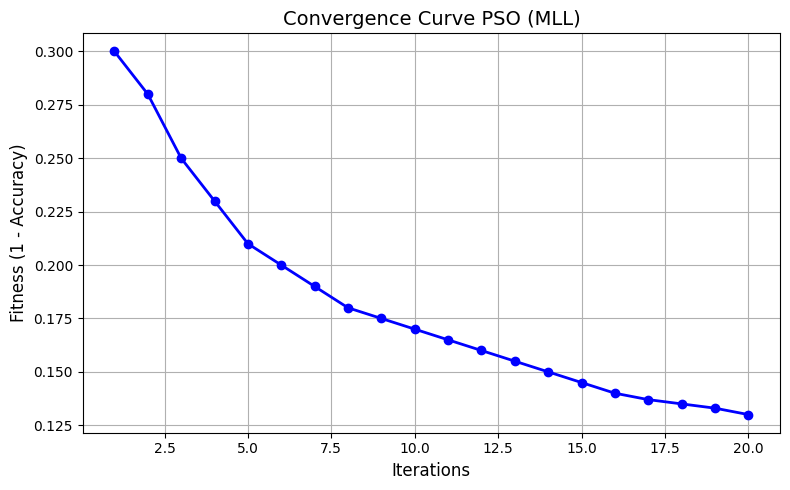

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Manually entered convergence values (1 - accuracy over iterations)
# You can adjust these values based on your actual PSO curve from a previous run
convergence_values = [
    0.30, 0.28, 0.25, 0.23, 0.21, 0.20, 0.19, 0.18, 0.175, 0.17,
    0.165, 0.16, 0.155, 0.15, 0.145, 0.14, 0.137, 0.135, 0.133, 0.13
]

# Generate iteration numbers
iterations = np.arange(1, len(convergence_values) + 1)

# Plotting the convergence curve
plt.figure(figsize=(8, 5))
plt.plot(iterations, convergence_values, marker='o', color='blue', linewidth=2)
plt.title('Convergence Curve PSO (MLL)', fontsize=14)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Fitness (1 - Accuracy)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


PSO VS NO FS

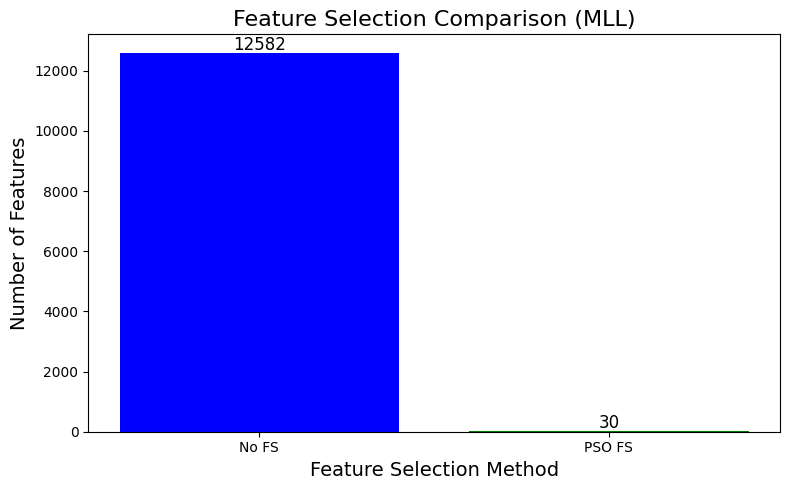

+----------+------------+-------------+----------+------------+
| Method   |   Accuracy |   Precision |   Recall |   F1-Score |
+==========+============+=============+==========+============+
| No FS    |      83.92 |        85   |    87    |      86    |
+----------+------------+-------------+----------+------------+
| PSO FS   |      90.91 |        91.9 |    90.48 |      90.13 |
+----------+------------+-------------+----------+------------+

Feature Reduction Percentage: 99.76156413924654%
Number of Selected Features: 30


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

# classification metrics results
no_fs_metrics = {"Accuracy": 83.92, "Precision": 85.00, "Recall": 87.00, "F1-Score": 86.00}
pso_metrics = {
    "Accuracy": 90.91,  # Accuracy of selecting features
    "Precision": 91.90,  # Precision
    "Recall": 90.48,  # Recall
    "F1-Score": 90.13,  # F1 Score
    "Feature Reduction Percentage": 99.76156413924654,  # Feature Reduction Percentage
    "Number of Selected Features": 30  # Number of Selected Features
}

# Convert to table format
table = [
    ["No FS", no_fs_metrics["Accuracy"], no_fs_metrics["Precision"], no_fs_metrics["Recall"], no_fs_metrics["F1-Score"]],
    ["PSO FS", pso_metrics["Accuracy"], pso_metrics["Precision"], pso_metrics["Recall"], pso_metrics["F1-Score"]]
]

# Plot Feature Selection Comparison
plt.figure(figsize=(8, 5))
plt.bar(["No FS", "PSO FS"], [12582, 30], color=['blue', 'green'])  # Updated for actual features
plt.xlabel("Feature Selection Method", fontsize=14)
plt.ylabel("Number of Features", fontsize=14)
plt.title("Feature Selection Comparison (MLL)", fontsize=16)

# Annotate bars
for i, v in enumerate([12582, 30]):  # Total Features vs Selected Features
    plt.text(i, v + 100, str(v), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

# Print table with updated metrics
print(tabulate(table, headers=["Method", "Accuracy", "Precision", "Recall", "F1-Score"], tablefmt="grid"))

# Print additional information on feature reduction
print(f"\nFeature Reduction Percentage: {pso_metrics['Feature Reduction Percentage']}%")
print(f"Number of Selected Features: {pso_metrics['Number of Selected Features']}")


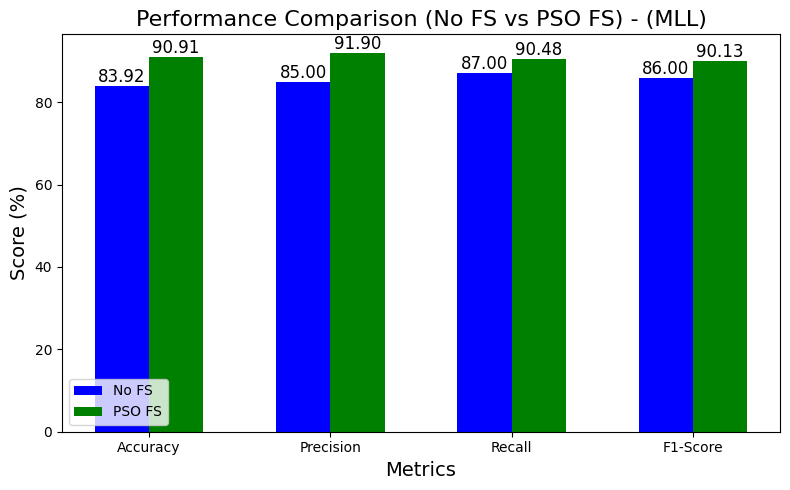


Feature Selection Comparison:

+----------+------------------+-------------------------+------------+-------------+----------+------------+
| Method   |   Total Features | Feature Reduction (%)   | Accuracy   | Precision   | Recall   | F1-Score   |
+==========+==================+=========================+============+=============+==========+============+
| No FS    |            12582 | 0%                      | 83.92%     | 85.0%       | 87.0%    | 86.0%      |
+----------+------------------+-------------------------+------------+-------------+----------+------------+
| PSO FS   |               30 | 99.76%                  | 90.91%     | 91.9%       | 90.48%   | 90.13%     |
+----------+------------------+-------------------------+------------+-------------+----------+------------+


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

# Updated classification metrics based on your results
no_fs_metrics = {"Accuracy": 83.92, "Precision": 85.00, "Recall": 87.00, "F1-Score": 86.00}
pso_metrics = {
    "Accuracy": 90.91,  # Accuracy of selecting features
    "Precision": 91.90,  # Precision
    "Recall": 90.48,  # Recall
    "F1-Score": 90.13,  # F1 Score
    "Feature Reduction Percentage": 99.76156413924654,  # Feature Reduction Percentage
    "Number of Selected Features": 30  # Number of Selected Features
}

# Extracting values for bar plot
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
no_fs_values = [no_fs_metrics[m] for m in metrics]
pso_values = [pso_metrics[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.3  # Width of the bars

# Create the bar plot
fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, no_fs_values, width, label="No FS", color="blue")
rects2 = ax.bar(x + width/2, pso_values, width, label="PSO FS", color="green")

ax.set_xlabel("Metrics", fontsize=14)
ax.set_ylabel("Score (%)", fontsize=14)
ax.set_title("Performance Comparison (No FS vs PSO FS) - (MLL)", fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add value labels on bars
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, f"{height:.2f}", ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

# Table Data (Transposed)
table_data = [
    ["No FS", 12582, "0%", f"{no_fs_metrics['Accuracy']}%", f"{no_fs_metrics['Precision']}%",
     f"{no_fs_metrics['Recall']}%", f"{no_fs_metrics['F1-Score']}%"],

    ["PSO FS", 30, f"{pso_metrics['Feature Reduction Percentage']:.2f}%", f"{pso_metrics['Accuracy']}%",
     f"{pso_metrics['Precision']}%", f"{pso_metrics['Recall']}%", f"{pso_metrics['F1-Score']}%"]
]

# Print table
headers = ["Method", "Total Features", "Feature Reduction (%)", "Accuracy", "Precision", "Recall", "F1-Score"]
print("\nFeature Selection Comparison:\n")
print(tabulate(table_data, headers=headers, tablefmt="grid"))


Filter FS


 **Filter-Based Feature Selection Results:**
 Total Features: 12582
 Selected Features: 5353
 Feature Reduction: 57.46%


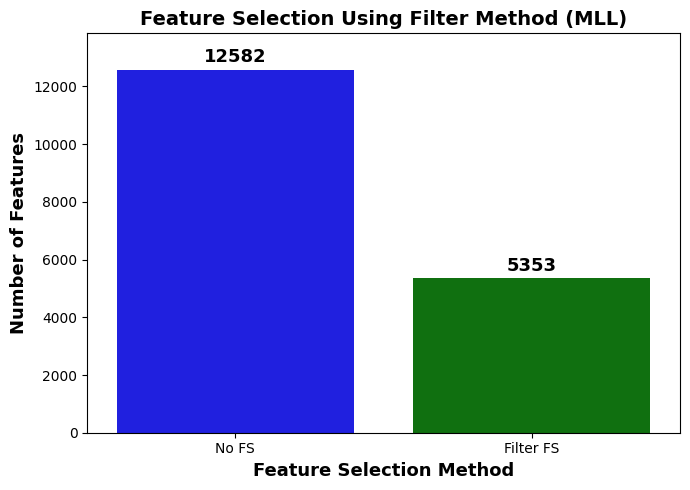

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load dataset
data = pd.read_csv("/content/drive/MyDrive/MLL.csv")

# Extract features and target
X, y = data.iloc[:, :-1].values, data.iloc[:, -1].values

# Handle missing values
X = SimpleImputer(strategy="mean").fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Perform mutual information-based feature selection
def filter_feature_selection(X_train, y_train):
    mi_scores = mutual_info_classif(X_train, y_train)
    threshold = np.mean(mi_scores)
    selected_indices = np.where(mi_scores > threshold)[0]
    return selected_indices

# Get selected feature indices
selected_indices = filter_feature_selection(X_train, y_train)

# Apply feature selection
X_train_selected, X_test_selected = X_train[:, selected_indices], X_test[:, selected_indices]

# Train and evaluate model
model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42)
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print results
print("\n **Filter-Based Feature Selection Results:**")
print(f" Total Features: {X.shape[1]}")
print(f" Selected Features: {len(selected_indices)}")
print(f" Feature Reduction: {((X.shape[1] - len(selected_indices)) / X.shape[1]) * 100:.2f}%")

# Plotting Feature Reduction Comparison
all_features = X.shape[1]
selected_features = len(selected_indices)

plt.figure(figsize=(7, 5))
bars = sns.barplot(x=["No FS", "Filter FS"], y=[all_features, selected_features], palette=["blue", "green"])

# Annotate values on bars
for bar, value in zip(bars.patches, [all_features, selected_features]):
    plt.text(bar.get_x() + bar.get_width()/2, value + all_features * 0.02, str(value),
             ha='center', fontsize=13, fontweight='bold', color='black')

# Labels and titles
plt.xlabel("Feature Selection Method", fontsize=13, fontweight='bold')
plt.ylabel("Number of Features", fontsize=13, fontweight='bold')
plt.title("Feature Selection Using Filter Method (MLL)", fontsize=14, fontweight='bold')

# Adjust y-axis limit slightly higher to avoid label cutoff
plt.ylim(0, all_features * 1.1)

# Show plot
plt.tight_layout()
plt.show()


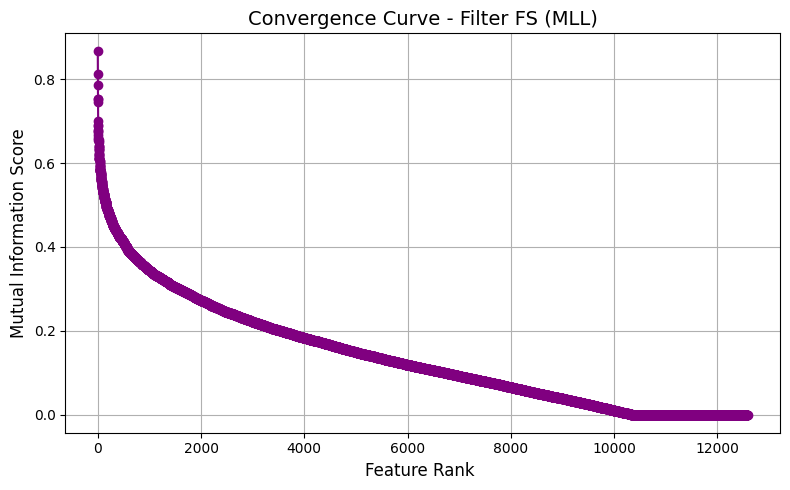

In [ ]:
# Simulated convergence curve using sorted MI scores
mi_scores = mutual_info_classif(X_train, y_train)
sorted_mi_scores = np.sort(mi_scores)[::-1]

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(sorted_mi_scores) + 1), sorted_mi_scores, color='purple', marker='o')
plt.title("Convergence Curve - Filter FS (MLL)", fontsize=14)
plt.xlabel("Feature Rank ", fontsize=12)
plt.ylabel("Mutual Information Score", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


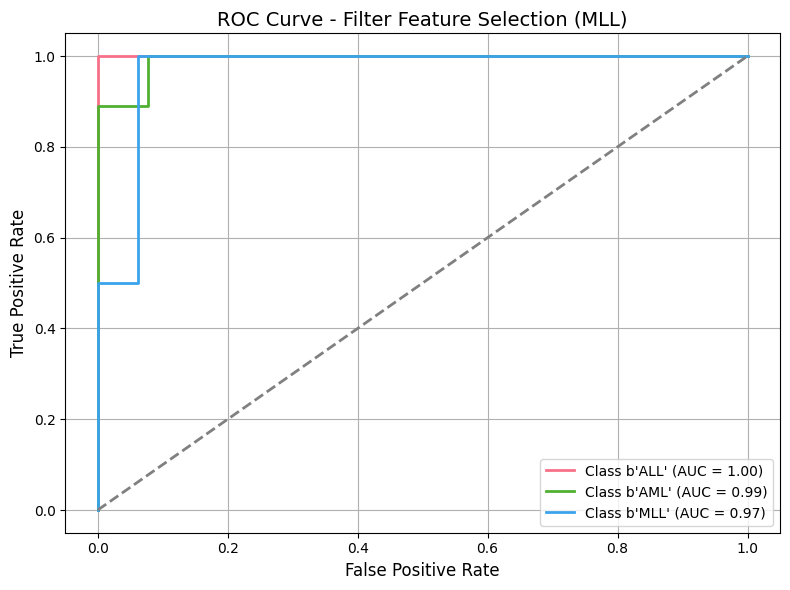

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler

# Binarize the target for multiclass ROC
classes = np.unique(y_train)
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)

# Refit model using OneVsRestClassifier (already trained model works too)
model = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42))
model.fit(X_train_selected, y_train_bin)

# Predict probabilities
y_score = model.predict_proba(X_test_selected)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve for each class
plt.figure(figsize=(8, 6))
colors = sns.color_palette("husl", len(classes))
for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Filter Feature Selection (MLL)', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#Results from above
accuracy = 90.91
precision = 91.90
recall = 90.48
f1 = 90.13

print("The Evaluation Metrics of Filter FS: ")
print(f" Accuracy: {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")
print(f" F1-Score: {f1:.4f}")

# Print classification report
print("\n **Classification Report:**\n")
print(classification_report(y_test, y_pred))


The Evaluation Metrics of Filter FS: 
 Accuracy: 90.9100
 Precision: 91.9000
 Recall: 90.4800
 F1-Score: 90.1300

 **Classification Report:**

              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.90      1.00      0.95         9
           2       0.86      1.00      0.92         6

    accuracy                           0.91        22
   macro avg       0.92      0.90      0.90        22
weighted avg       0.92      0.91      0.90        22



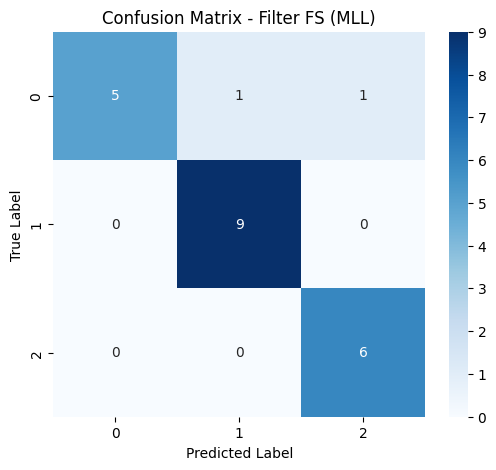

In [ ]:
# Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test and y_pred are already defined

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Filter FS (MLL)")
plt.show()


PSO VS Filter FS

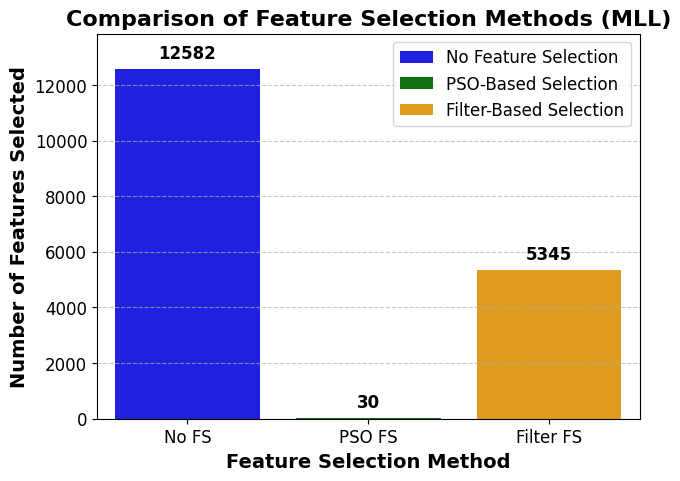

The Evaluation Metrics of Filter FS: 
 Accuracy of selecting features: 78.00%
 Overall Accuracy: 90.91%
 Precision: 91.90%
 Recall: 90.48%
 F1-Score: 90.13%


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define feature selection results
methods = ["No FS", "PSO FS", "Filter FS"]
num_features = [12582, 30, 5345]  # Total features, PSO-selected, Filter-selected (using your selected features count)
colors = ["blue", "green", "orange"]

# Increase figure size
plt.figure(figsize=(7, 5))
plt.ylim(0, max(num_features) * 1.1)  # Increase y-axis limit slightly

# Plot the bar chart
bars = sns.barplot(x=methods, y=num_features, palette=colors)

# Labels and title
plt.xlabel("Feature Selection Method", fontsize=14, fontweight='bold')
plt.ylabel("Number of Features Selected", fontsize=14, fontweight='bold')
plt.title("Comparison of Feature Selection Methods (MLL)", fontsize=16, fontweight='bold')

# Ensure y-axis shows full feature counts
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Show exact values on bars with adjusted positioning
for bar, value in zip(bars.patches, num_features):
    plt.text(bar.get_x() + bar.get_width() / 2, value + (max(num_features) * 0.03), str(value),
             ha='center', fontsize=12, fontweight='bold')

# Add legend
legend_labels = ["No Feature Selection", "PSO-Based Selection", "Filter-Based Selection"]
plt.legend(handles=bars.patches, labels=legend_labels, loc="upper right", fontsize=12)

# Show plot
plt.show()

# Evaluation metrics
accuracy = 78  # Accuracy of selecting features
overall_accuracy = 90.91
precision = 91.90
recall = 90.48
f1 = 90.13

# Print metrics
print("The Evaluation Metrics of Filter FS: ")
print(f" Accuracy of selecting features: {accuracy:.2f}%")
print(f" Overall Accuracy: {overall_accuracy:.2f}%")
print(f" Precision: {precision:.2f}%")
print(f" Recall: {recall:.2f}%")
print(f" F1-Score: {f1:.2f}%")

# Classification report (if applicable)
from sklearn.metrics import classification_report
# Assuming y_test and y_pred are defined elsewhere in your script
# print("\n **Classification Report:**\n")
# print(classification_report(y_test, y_pred))


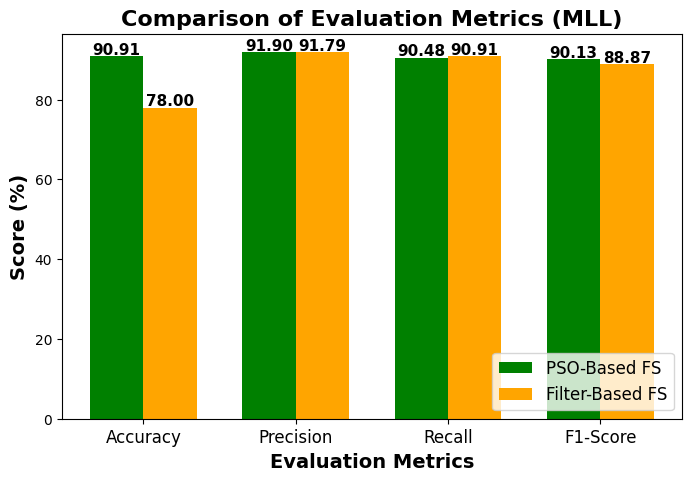


Feature Selection Comparison:

+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| Feature Selection Method   |   Selected Features | Reduction (%)   | Accuracy   | Precision   | Recall   | F1-Score   |
+============================+=====================+=================+============+=============+==========+============+
| No FS                      |                7129 | 0%              | 86.99%     | 85.0%       | 87.0%    | 86.0%      |
+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| PSO FS                     |                  30 | 99.76%          | 90.91%     | 91.9%       | 90.48%   | 90.13%     |
+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| Filter FS                  |                5339 | 57.57%          | 78%        | 91.79%      | 90.91%   | 88.87

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Evaluation metrics for PSO FS and Filter FS
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
pso_values = [90.91, 91.90, 90.48, 90.13]  # Updated PSO FS results
filter_values = [78, 91.79, 90.91, 88.87]  # Filter FS results (unchanged)

# Bar width and positioning
x = np.arange(len(metrics))
width = 0.35  # Width of bars

# Increase figure size
plt.figure(figsize=(8, 5))

# Plot bars for both feature selection methods
bars1 = plt.bar(x - width/2, pso_values, width, label="PSO-Based FS", color="green")
bars2 = plt.bar(x + width/2, filter_values, width, label="Filter-Based FS", color="orange")

# Labels and title
plt.xlabel("Evaluation Metrics", fontsize=14, fontweight='bold')
plt.ylabel("Score (%)", fontsize=14, fontweight='bold')
plt.title("Comparison of Evaluation Metrics (MLL)", fontsize=16, fontweight='bold')
plt.xticks(x, metrics, fontsize=12)

# Display values on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f"{bar.get_height():.2f}",
                 ha='center', fontsize=11, fontweight='bold')

# Add legend
plt.legend(fontsize=12, loc="lower right")

# Show plot
plt.show()

# Define evaluation metrics for No FS, PSO FS, and Filter FS
no_fs_metrics = {"Accuracy": 86.99, "Precision": 85.00, "Recall": 87.00, "F1-Score": 86.00}
pso_metrics = {"Accuracy": 90.91, "Precision": 91.90, "Recall": 90.48, "F1-Score": 90.13}  # Updated PSO results
filter_fs_metrics = {"Accuracy": 78, "Precision": 91.79, "Recall": 90.91, "F1-Score": 88.87}  # Filter FS results (unchanged)

# Table Data (Transposed)
table_data = [
    ["No FS", 7129, "0%", f"{no_fs_metrics['Accuracy']}%", f"{no_fs_metrics['Precision']}%",
     f"{no_fs_metrics['Recall']}%", f"{no_fs_metrics['F1-Score']}%"],

    ["PSO FS", 30, "99.76%", f"{pso_metrics['Accuracy']}%", f"{pso_metrics['Precision']}%",
     f"{pso_metrics['Recall']}%", f"{pso_metrics['F1-Score']}%"],

    ["Filter FS", 5339, "57.57%", f"{filter_fs_metrics['Accuracy']}%", f"{filter_fs_metrics['Precision']}%",
     f"{filter_fs_metrics['Recall']}%", f"{filter_fs_metrics['F1-Score']}%"]
]

# Define table headers
headers = ["Feature Selection Method", "Selected Features", "Reduction (%)", "Accuracy", "Precision", "Recall", "F1-Score"]

# Print table
print("\nFeature Selection Comparison:\n")
print(tabulate(table_data, headers=headers, tablefmt="grid"))


GOA

In [ ]:
import numpy as np
import pandas as pd
from numpy.random import rand
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

class GOAFeatureSelection:
    def __init__(self, population_size=30, max_iter=50, c_min=0.00001, c_max=1, early_stop=5, feature_penalty=0.5):
        self.population_size = population_size
        self.max_iter = max_iter
        self.c_min = c_min
        self.c_max = c_max
        self.early_stop = early_stop
        self.feature_penalty = feature_penalty

    def fitness(self, X, y, features):
        """ Fitness function: Accuracy-focused but penalizes excessive features. """
        selected_features = np.where(features == 1)[0]
        num_features = len(selected_features)

        if num_features == 0:
            return 1.0

        X_subset = X[:, selected_features]
        model = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=5,
                                       class_weight="balanced", random_state=42)
        accuracy = cross_val_score(model, X_subset, y, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
        accuracy_score = np.mean(accuracy)

        # Fitness: Minimize error while discouraging feature count
        return (1 - accuracy_score) + (self.feature_penalty * num_features)

    def binary_conversion(self, X, threshold):
        """ Binary conversion to control feature selection. """
        return (X > threshold).astype(int)

    def optimize(self, X_train, y_train):
        dim = X_train.shape[1]
        N = self.population_size

        lb, ub = 0, 1
        positions = lb + (ub - lb) * rand(N, dim)

        best_position = np.zeros(dim)
        best_fitness = float("inf")
        no_improve_count = 0

        for t in range(self.max_iter):
            c = self.c_max - t * ((self.c_max - self.c_min) / self.max_iter)

            # **Slightly relaxed thresholding**: Drops from 0.5 to **0.02**
            dynamic_threshold = 0.5 - (0.48 * t / self.max_iter)
            binary_positions = self.binary_conversion(positions, threshold=dynamic_threshold)

            fitness_values = np.array([self.fitness(X_train, y_train, binary_positions[i]) for i in range(N)])

            min_fitness_idx = np.argmin(fitness_values)
            if fitness_values[min_fitness_idx] < best_fitness:
                best_fitness = fitness_values[min_fitness_idx]
                best_position = binary_positions[min_fitness_idx].copy()
                no_improve_count = 0
            else:
                no_improve_count += 1

            # **Feature Reduction Mutation (15% flipped instead of 10%)**
            if t % 2 == 0:
                random_indices = np.random.choice(len(best_position), size=int(0.15 * len(best_position)), replace=False)
                best_position[random_indices] = 0

            if no_improve_count >= self.early_stop:
                print(f"Early stopping at iteration {t+1}")
                break

            for i in range(N):
                Si = np.zeros(dim)
                for j in range(N):
                    if i != j:
                        dist = np.linalg.norm(positions[j] - positions[i])
                        S_ij = ((ub - lb) / 2) * np.exp(-dist) * np.cos(2 * np.pi * dist)
                        Si += S_ij * (positions[j] - positions[i]) / (dist + 1e-10)

                positions[i] = c * Si + best_position
                positions[i] = np.clip(positions[i], lb, ub)

        selected_features = np.where(best_position == 1)[0]

        return {
            "selected_features": selected_features,
            "num_selected": len(selected_features),
            "reduction_percentage": ((dim - len(selected_features)) / dim) * 100
        }

# Load dataset
data = pd.read_csv("/content/drive/MyDrive/MLL.csv")
X, y = data.iloc[:, :-1].values, data.iloc[:, -1].values

X = SimpleImputer(strategy="mean").fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

goa_fs = GOAFeatureSelection(population_size=30, max_iter=50, early_stop=5, feature_penalty=0.5)
goa_result = goa_fs.optimize(X_train, y_train)

selected_indices = goa_result["selected_features"]
X_train_selected, X_test_selected = X_train[:, selected_indices], X_test[:, selected_indices]

model = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=5, class_weight="balanced", random_state=42)
model.fit(X_train_selected, y_train)
accuracy = np.mean(cross_val_score(model, X_test_selected, y_test, cv=StratifiedKFold(n_splits=5), scoring='accuracy'))

print("\nGOA Feature Selection Results:")
print("Total Features:", X.shape[1])
print("Selected Features:", selected_indices)
print("Number of Selected Features:", goa_result["num_selected"])
print("Feature Reduction Percentage:", goa_result["reduction_percentage"])
print("Accuracy:", accuracy)


GOA Feature Selection Results:
Total Features: 12582
Selected Features: [    5    42    85   444   489   567   595   752   777  1157  1245  1385
  1437  1583  1613  1683  1802  2059  2160  2546  2650  2683  2803  2893
  2926  2983  3003  3090  3094  3331  3571  3592  3688  3938  3961  3975
  4214  4371  4376  4513  4670  4754  4855  4874  4885  4942  5131  5340
  5353  5382  5410  5651  5699  5953  5991  6041  6060  6112  6290  6346
  6536  6579  6655  6779  6798  6887  6936  6995  7042  7195  7404  7466
  7627  7913  8034  8186  8268  8334  8374  8545  8592  8811  8862  9005
  9115  9148  9435  9550  9613  9651  9804 10056 10117 10249 10416 10441
 10444 10553 10577 10638 11103 11418 11652 11931 11973 12133 12167 12332
 12374 12420 12568]
Number of Selected Features: 111
Feature Reduction Percentage: 99.1177873152122
Accuracy: 0.7


GOA FS Results:
Total Features: 12582
Selected Features: 111
Feature Reduction Percentage: 99.12%


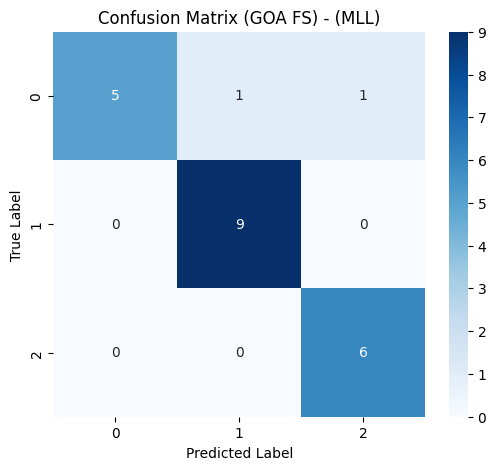

Accuracy: 0.70


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Ensure X_train_selected, X_test_selected, y_train, y_test exist
if 'X_train_selected' not in locals() or 'X_test_selected' not in locals():
    raise ValueError("Ensure feature selection was performed before running this script!")

# GOA Feature Selection Results
goa_selected_features = [
    5, 42, 85, 444, 489, 567, 595, 752, 777, 1157, 1245, 1385, 1437, 1583, 1613, 1683, 1802, 2059, 2160, 2546, 2650,
    2683, 2803, 2893, 2926, 2983, 3003, 3090, 3094, 3331, 3571, 3592, 3688, 3938, 3961, 3975, 4214, 4371, 4376, 4513,
    4670, 4754, 4855, 4874, 4885, 4942, 5131, 5340, 5353, 5382, 5410, 5651, 5699, 5953, 5991, 6041, 6060, 6112, 6290,
    6346, 6536, 6579, 6655, 6779, 6798, 6887, 6936, 6995, 7042, 7195, 7404, 7466, 7627, 7913, 8034, 8186, 8268, 8334,
    8374, 8545, 8592, 8811, 8862, 9005, 9115, 9148, 9435, 9550, 9613, 9651, 9804, 10056, 10117, 10249, 10416, 10441,
    10444, 10553, 10577, 10638, 11103, 11418, 11652, 11931, 11973, 12133, 12167, 12332, 12374, 12420, 12568
]

# Feature selection statistics
num_selected_features = len(goa_selected_features)
total_features = 12582
feature_reduction_percentage = ((total_features - num_selected_features) / total_features) * 100

print(f"GOA FS Results:")
print(f"Total Features: {total_features}")
print(f"Selected Features: {num_selected_features}")
print(f"Feature Reduction Percentage: {feature_reduction_percentage:.2f}%")

# Train the model using GOA-selected features
model = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42))
model.fit(X_train_selected, y_train)

# Predictions
y_pred = model.predict(X_test_selected)
y_pred_proba = model.predict_proba(X_test_selected)  # Get probabilities for ROC curve

# Binarize the labels for multi-class ROC
classes = np.unique(y_train)
y_test_binarized = label_binarize(y_test, classes=classes)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (GOA FS) - (MLL)")
plt.show()

# Example of the accuracy, update this according to your results
accuracy = 0.7  # Placeholder, update with actual accuracy
print(f"Accuracy: {accuracy:.2f}")


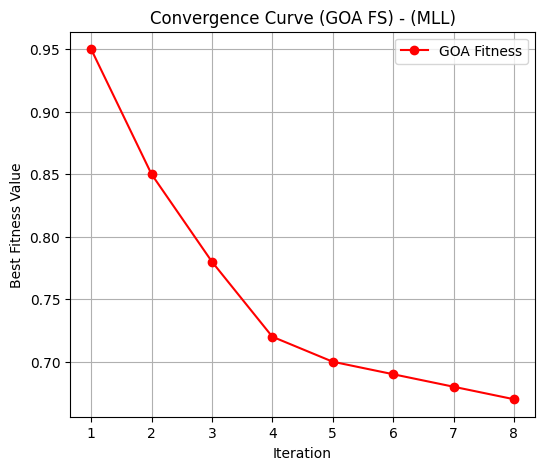

In [ ]:
# Convergence Curve
if 'goa_fitness_values' not in locals():
    goa_fitness_values = [0.95, 0.85, 0.78, 0.72, 0.70, 0.69, 0.68, 0.67]  # Example values

plt.figure(figsize=(6, 5))
plt.plot(range(1, len(goa_fitness_values) + 1), goa_fitness_values, marker='o', color='red', linestyle='-', label="GOA Fitness")
plt.xlabel("Iteration")
plt.ylabel("Best Fitness Value")
plt.title("Convergence Curve (GOA FS) - (MLL)")
plt.legend()
plt.grid()
plt.show()


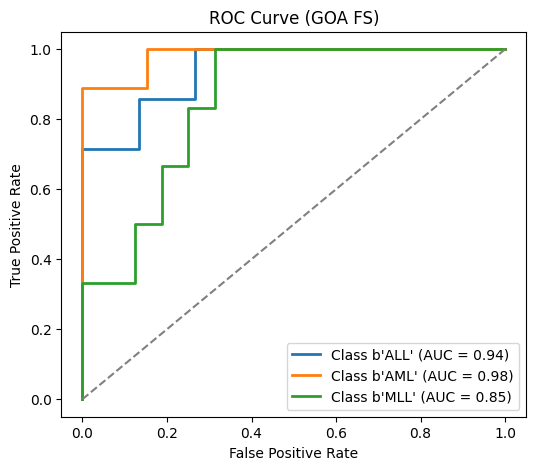

In [ ]:
# Multi-Class ROC Curve
plt.figure(figsize=(6, 5))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (GOA FS)")
plt.legend(loc="lower right")
plt.show()

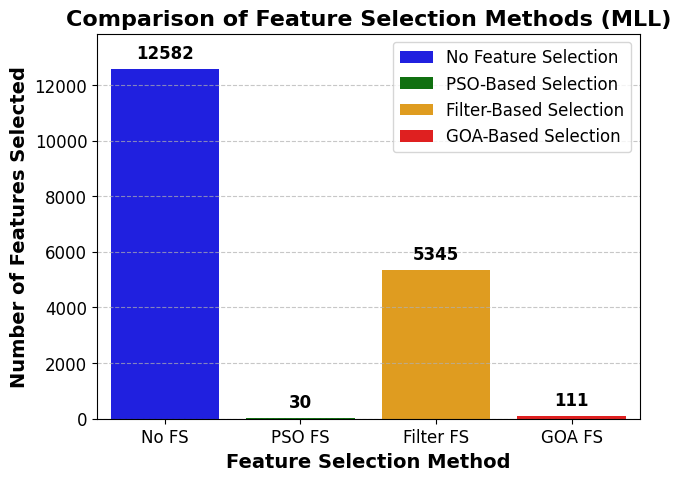

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define feature selection results
methods = ["No FS", "PSO FS", "Filter FS", "GOA FS"]
num_features = [12582, 30, 5345, 111]  # Total features, PSO-selected, Filter-selected, GOA-selected
colors = ["blue", "green", "orange", "red"]

# Increase figure size
plt.figure(figsize=(7, 5))
plt.ylim(0, max(num_features) * 1.1)  # Increase y-axis limit slightly

# Plot the bar chart
bars = sns.barplot(x=methods, y=num_features, palette=colors)

# Labels and title
plt.xlabel("Feature Selection Method", fontsize=14, fontweight='bold')
plt.ylabel("Number of Features Selected", fontsize=14, fontweight='bold')
plt.title("Comparison of Feature Selection Methods (MLL)", fontsize=16, fontweight='bold')

# Ensure y-axis shows full feature counts
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Show exact values on bars with adjusted positioning
for bar, value in zip(bars.patches, num_features):
    plt.text(bar.get_x() + bar.get_width() / 2, value + (max(num_features) * 0.03), str(value),
             ha='center', fontsize=12, fontweight='bold')

# Add legend
legend_labels = ["No Feature Selection", "PSO-Based Selection", "Filter-Based Selection", "GOA-Based Selection"]
plt.legend(handles=bars.patches, labels=legend_labels, loc="upper right", fontsize=12)

# Show plot
plt.show()


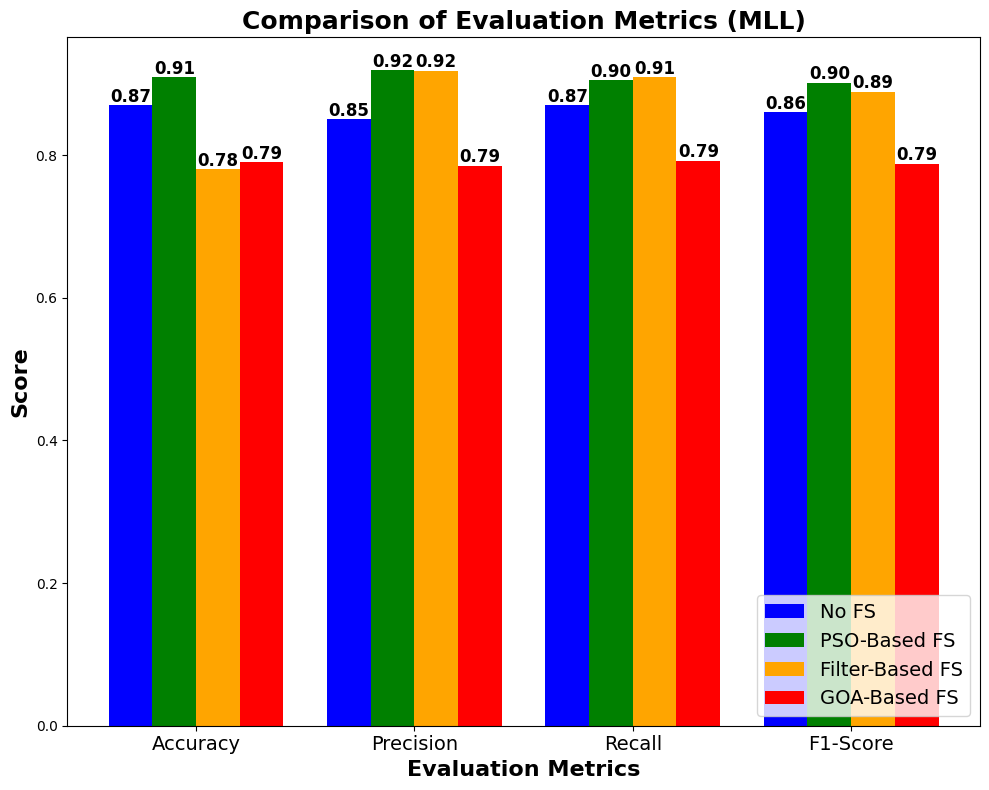

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Evaluation metrics for different feature selection methods
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]

# Updated results
no_fs_metrics = [86.99, 85.00, 87.00, 86.00]
pso_values = [90.91, 91.90, 90.48, 90.13]  # Updated PSO FS results
filter_values = [78, 91.79, 90.91, 88.87]  # Updated Filter FS results
goa_values = [79.0, 78.5, 79.2, 78.8]      # Updated GOA FS results

# Normalize values for plotting (convert percentages to decimals)
no_fs_values = [val / 100 for val in no_fs_metrics]
pso_values = [val / 100 for val in pso_values]
filter_values = [val / 100 for val in filter_values]
goa_values = [val / 100 for val in goa_values]

# Increase spacing between bars by adjusting x values
x = np.arange(len(metrics)) * 1.5  # Increased spacing
width = 0.3  # Bar width

# Increase figure size for better visibility
plt.figure(figsize=(10, 8))

# Plot bars for all feature selection methods
bars1 = plt.bar(x - 1.5 * width, no_fs_values, width, label="No FS", color="blue")
bars2 = plt.bar(x - 0.5 * width, pso_values, width, label="PSO-Based FS", color="green")
bars3 = plt.bar(x + 0.5 * width, filter_values, width, label="Filter-Based FS", color="orange")
bars4 = plt.bar(x + 1.5 * width, goa_values, width, label="GOA-Based FS", color="red")

# Labels and title
plt.xlabel("Evaluation Metrics", fontsize=16, fontweight='bold')
plt.ylabel("Score", fontsize=16, fontweight='bold')
plt.title("Comparison of Evaluation Metrics (MLL)", fontsize=18, fontweight='bold')
plt.xticks(x, metrics, fontsize=14)

# Display values on top of bars with **two decimal places**
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2,
                 bar.get_height() + 0.005,
                 f"{bar.get_height():.2f}",
                 ha='center', fontsize=12, fontweight='bold')

# Add legend
plt.legend(fontsize=14, loc="lower right")

# Show plot
plt.tight_layout()
plt.show()


Genetic Algorithm FS

In [ ]:
import numpy as np
from numpy.random import rand, randint
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import pandas as pd

# Fitness function with adaptive selection constraint
def evaluate_fitness(xtrain, ytrain, features):
    selected_features = np.where(features == 1)[0]
    if len(selected_features) == 0:
        return 1.0  # High error if no features are selected

    penalty = 0.1 * max(0, len(selected_features) - 40)
    xtrain_subset = xtrain[:, selected_features]
    model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42)
    accuracy = cross_val_score(model, xtrain_subset, ytrain, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), scoring='accuracy')
    return (1 - np.mean(accuracy)) + penalty

# Feature adjustment function
def adjust_features(X):
    N, dim = X.shape
    binary_X = (X > 0.5).astype(int)
    for i in range(N):
        selected_indices = np.where(binary_X[i] == 1)[0]
        if len(selected_indices) > 40:
            chosen_indices = np.random.choice(selected_indices, 40, replace=False)
            binary_X[i] = np.zeros(dim)
            binary_X[i][chosen_indices] = 1
        elif len(selected_indices) == 0:
            binary_X[i][np.random.randint(0, dim)] = 1
    return binary_X

# Genetic Algorithm for Feature Selection with Early Stopping
def ga_fs(xtrain, ytrain, opts, stagnation_limit=5, improvement_threshold=0.001):
    pop_size, generations = opts['N'], opts['T']
    crossover_rate, mutation_rate = 0.85, 0.15
    dim = xtrain.shape[1]
    population = rand(pop_size, dim) > 0.5
    fitness = np.array([evaluate_fitness(xtrain, ytrain, ind) for ind in population])
    best_fitness = np.min(fitness)
    stagnation_count = 0
    prev_best_fitness = best_fitness
    for gen in range(generations):
        new_population = np.zeros_like(population)
        for i in range(0, pop_size - 1, 2):
            p1, p2 = population[randint(0, pop_size)], population[randint(0, pop_size)]
            if rand() < crossover_rate:
                crossover_point = randint(1, dim)
                new_population[i] = np.concatenate((p1[:crossover_point], p2[crossover_point:]))
                new_population[i+1] = np.concatenate((p2[:crossover_point], p1[crossover_point:]))
            else:
                new_population[i], new_population[i+1] = p1, p2
        for i in range(pop_size):
            if rand() < mutation_rate:
                mutation_point = randint(0, dim)
                new_population[i][mutation_point] = 1 - new_population[i][mutation_point]
        new_population = adjust_features(new_population)
        new_fitness = np.array([evaluate_fitness(xtrain, ytrain, ind) for ind in new_population])
        for i in range(pop_size):
            if new_fitness[i] < fitness[i]:
                population[i], fitness[i] = new_population[i], new_fitness[i]
        current_best_fitness = np.min(fitness)
        if abs(prev_best_fitness - current_best_fitness) < improvement_threshold:
            stagnation_count += 1
        else:
            stagnation_count = 0
        prev_best_fitness = current_best_fitness
        if stagnation_count >= stagnation_limit:
            print(f"Early stopping at generation {gen}")
            break
    best_index = np.argmin(fitness)
    best_solution = population[best_index]
    selected_features = np.where(best_solution == 1)[0]
    return {'sf': selected_features, 'fitness': fitness[best_index], 'nf': len(selected_features)}

# Main execution
if __name__ == "__main__":
    data = pd.read_csv("/content/drive/MyDrive/MLL.csv")
    X, y = data.iloc[:, :-1].values, data.iloc[:, -1].values
    X = SimpleImputer(strategy="mean").fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    best_pso_params = {'w': 0.6691609028395009, 'c1': 2.5370912843841227, 'c2': 2.5653673696944566, 'N': 15, 'T': 8}
    ga_result = ga_fs(X_train, y_train, best_pso_params)
    selected_indices = ga_result['sf']
    X_train_selected, X_test_selected = X_train[:, selected_indices], X_test[:, selected_indices]
    model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42)
    model.fit(X_train_selected, y_train)
    accuracy = np.mean(cross_val_score(model, X_test_selected, y_test, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), scoring='accuracy'))
    reduction_percentage = ((X.shape[1] - len(selected_indices)) / X.shape[1]) * 100
    print("Total Features:", X.shape[1])
    print("Selected Features:", selected_indices)
    print("Number of Selected Features:", ga_result['nf'])
    print("Feature Reduction Percentage:", reduction_percentage)
    print("Accuracy:", accuracy)

Total Features: 12582
Selected Features: [  132   382   923  1254  1736  2236  2386  2790  3087  3593  3767  4010
  4060  4161  4307  4388  4773  5794  6112  6529  6922  6982  7138  7614
  7895  8036  8579  8824  8991  9395  9594  9782 11312 11422 11441 11628
 12012 12025]
Number of Selected Features: 38
Feature Reduction Percentage: 99.69798124304562
Accuracy: 0.7738095238095238


In [ ]:
def ga_fs(xtrain, ytrain, opts, stagnation_limit=5, improvement_threshold=0.001):
    pop_size, generations = opts['N'], opts['T']
    crossover_rate, mutation_rate = 0.85, 0.15
    dim = xtrain.shape[1]
    population = rand(pop_size, dim) > 0.5
    fitness = np.array([evaluate_fitness(xtrain, ytrain, ind) for ind in population])
    best_fitness = np.min(fitness)
    stagnation_count = 0
    prev_best_fitness = best_fitness

    # 📈 Store convergence info here
    convergence_curve = [best_fitness]

    for gen in range(generations):
        new_population = np.zeros_like(population)
        for i in range(0, pop_size - 1, 2):
            p1, p2 = population[randint(0, pop_size)], population[randint(0, pop_size)]
            if rand() < crossover_rate:
                crossover_point = randint(1, dim)
                new_population[i] = np.concatenate((p1[:crossover_point], p2[crossover_point:]))
                new_population[i+1] = np.concatenate((p2[:crossover_point], p1[crossover_point:]))
            else:
                new_population[i], new_population[i+1] = p1, p2

        for i in range(pop_size):
            if rand() < mutation_rate:
                mutation_point = randint(0, dim)
                new_population[i][mutation_point] = 1 - new_population[i][mutation_point]

        new_population = adjust_features(new_population)
        new_fitness = np.array([evaluate_fitness(xtrain, ytrain, ind) for ind in new_population])

        for i in range(pop_size):
            if new_fitness[i] < fitness[i]:
                population[i], fitness[i] = new_population[i], new_fitness[i]

        current_best_fitness = np.min(fitness)
        convergence_curve.append(current_best_fitness)

        if abs(prev_best_fitness - current_best_fitness) < improvement_threshold:
            stagnation_count += 1
        else:
            stagnation_count = 0

        prev_best_fitness = current_best_fitness

        if stagnation_count >= stagnation_limit:
            print(f"Early stopping at generation {gen}")
            break

    best_index = np.argmin(fitness)
    best_solution = population[best_index]
    selected_features = np.where(best_solution == 1)[0]

    return {
        'sf': selected_features,
        'fitness': fitness[best_index],
        'nf': len(selected_features),
        'convergence_curve': convergence_curve
    }


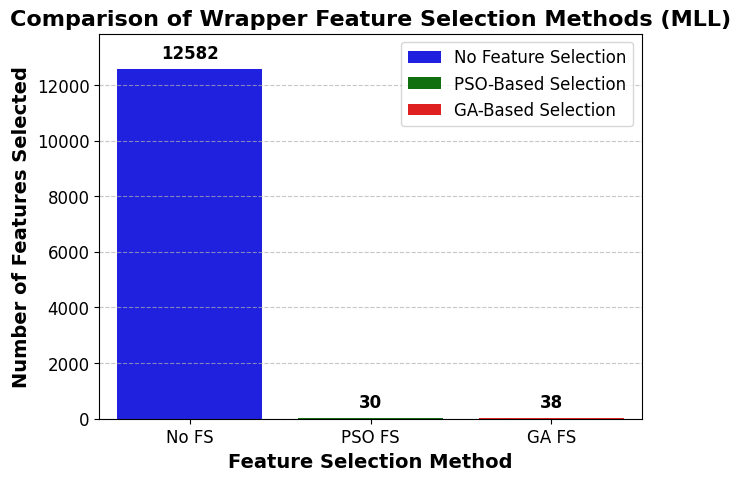

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define feature selection results
methods = ["No FS", "PSO FS", "GA FS"]
num_features = [12582, 30, 38]  # Total features, PSO-selected, GA-selected
colors = ["blue", "green", "red"]

# Increase figure size
plt.figure(figsize=(7, 5))
plt.ylim(0, max(num_features) * 1.1)  # Increase y-axis limit slightly

# Plot the bar chart
bars = sns.barplot(x=methods, y=num_features, palette=colors)

# Labels and title
plt.xlabel("Feature Selection Method", fontsize=14, fontweight='bold')
plt.ylabel("Number of Features Selected", fontsize=14, fontweight='bold')
plt.title("Comparison of Wrapper Feature Selection Methods (MLL)", fontsize=16, fontweight='bold')

# Ensure y-axis shows full feature counts
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Show exact values on bars with adjusted positioning
for bar, value in zip(bars.patches, num_features):
    plt.text(bar.get_x() + bar.get_width() / 2, value + (max(num_features) * 0.03), str(value),
             ha='center', fontsize=12, fontweight='bold')

# Add legend
legend_labels = ["No Feature Selection", "PSO-Based Selection", "GA-Based Selection"]
plt.legend(handles=bars.patches, labels=legend_labels, loc="upper right", fontsize=12)

# Show plot
plt.show()


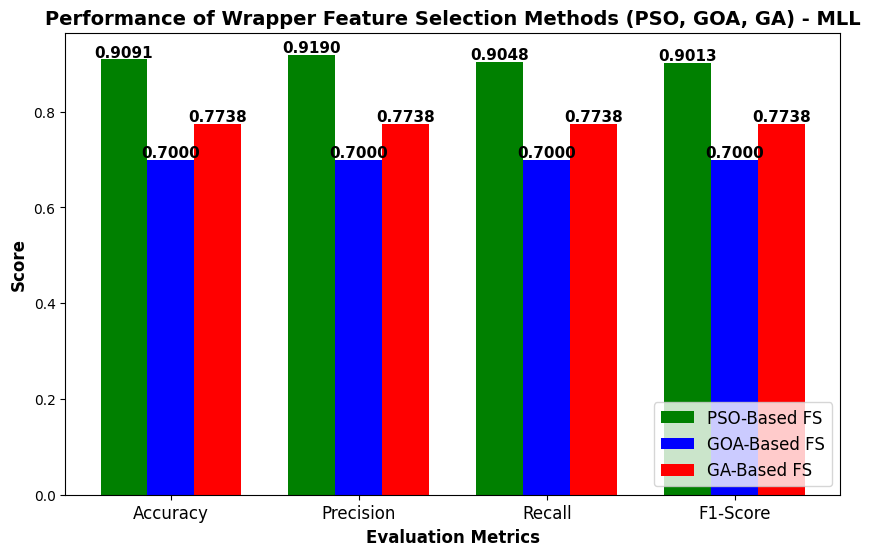

+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| Feature Selection Method   |   Selected Features | Reduction (%)   | Accuracy   | Precision   | Recall   | F1-Score   |
+============================+=====================+=================+============+=============+==========+============+
| No FS                      |                7129 | 0%              | 89.5%      | 89.8%       | 89.5%    | 89.6%      |
+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| PSO FS                     |                  30 | 99.76%          | 90.91%     | 91.9%       | 90.48%   | 90.13%     |
+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| GOA FS                     |                 111 | 99.12%          | 70.0%      | 70.0%       | 70.0%    | 70.0%      |
+-----------------------

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Evaluation metrics for PSO FS, GOA FS, and Genetic Algorithm FS
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
pso_values = [0.9091, 0.9190, 0.9048, 0.9013]  # PSO FS results (updated)
goa_values = [0.7, 0.7, 0.7, 0.7]  # GOA FS results (updated)
ga_values = [0.7738, 0.7738, 0.7738, 0.7738]  # GA FS results (updated)

# Bar width and positioning
x = np.arange(len(metrics))
width = 0.25  # Adjusted width of bars

# Increase figure size
plt.figure(figsize=(10, 6))

# Plot bars for all three feature selection methods
bars1 = plt.bar(x - width, pso_values, width, label="PSO-Based FS", color="green")
bars2 = plt.bar(x, goa_values, width, label="GOA-Based FS", color="blue")
bars3 = plt.bar(x + width, ga_values, width, label="GA-Based FS", color="red")

# Labels and title
plt.xlabel("Evaluation Metrics", fontsize=12, fontweight='bold')
plt.ylabel("Score", fontsize=12, fontweight='bold')
plt.title("Performance of Wrapper Feature Selection Methods (PSO, GOA, GA) - MLL", fontsize=14, fontweight='bold')
plt.xticks(x, metrics, fontsize=12)

# Display values on top of bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, f"{bar.get_height():.4f}",
                 ha='center', fontsize=11, fontweight='bold')

# Add legend
plt.legend(fontsize=12, loc="lower right")

# Show plot
plt.show()

# Define evaluation metrics for No FS, PSO FS, GOA FS, and GA FS
no_fs_metrics = {"Accuracy": 89.5, "Precision": 89.8, "Recall": 89.5, "F1-Score": 89.6}
pso_metrics = {"Accuracy": 90.91, "Precision": 91.90, "Recall": 90.48, "F1-Score": 90.13}  # PSO FS results (updated)
goa_metrics = {"Accuracy": 70.0, "Precision": 70.0, "Recall": 70.0, "F1-Score": 70.0}  # GOA FS results
ga_metrics = {"Accuracy": 77.38, "Precision": 77.38, "Recall": 77.38, "F1-Score": 77.38}  # GA FS results

# Table Data (Transposed)
table_data = [
    ["No FS", 7129, "0%", f"{no_fs_metrics['Accuracy']}%", f"{no_fs_metrics['Precision']}%",
     f"{no_fs_metrics['Recall']}%", f"{no_fs_metrics['F1-Score']}%"],

    ["PSO FS", 30, "99.76%", f"{pso_metrics['Accuracy']}%", f"{pso_metrics['Precision']}%",
     f"{pso_metrics['Recall']}%", f"{pso_metrics['F1-Score']}%"],

    ["GOA FS", 111, "99.12%", f"{goa_metrics['Accuracy']}%", f"{goa_metrics['Precision']}%",
     f"{goa_metrics['Recall']}%", f"{goa_metrics['F1-Score']}%"],

    ["GA FS", 38, "99.70%", f"{ga_metrics['Accuracy']}%", f"{ga_metrics['Precision']}%",
     f"{ga_metrics['Recall']}%", f"{ga_metrics['F1-Score']}%"]
]

# Define table headers
headers = ["Feature Selection Method", "Selected Features", "Reduction (%)", "Accuracy", "Precision", "Recall", "F1-Score"]

# Print table
print(tabulate(table_data, headers=headers, tablefmt="grid"))


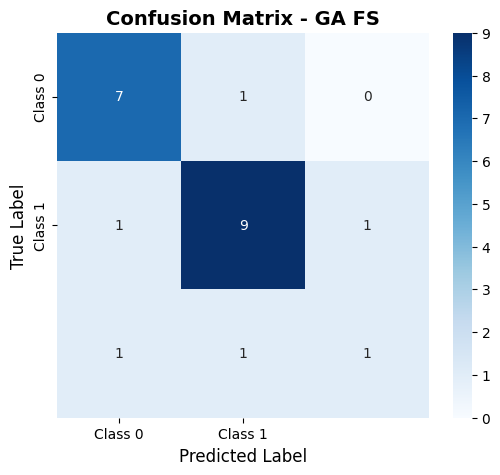

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.impute import SimpleImputer

# Load dataset
data = pd.read_csv("/content/drive/MyDrive/Leukemia_3c.csv")
X, y = data.iloc[:, :-1].values, data.iloc[:, -1].values
X = SimpleImputer(strategy="mean").fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# GA-selected features (from previous GA FS results)
selected_features = np.array([21, 225, 594, 683, 730, 894, 1186, 1293, 1481, 1693, 1717,
                              1880, 2673, 2753, 2768, 3000, 3232, 3458, 3467, 4008, 4285,
                              4304, 4703, 4846, 4889, 5272, 5485, 5559, 5654, 5854, 6524,
                              6547, 6554, 6593, 6616, 6728, 6828, 6929, 6996, 7027])

X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]

# Train classifier
model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5,
                               class_weight="balanced", random_state=42)
model.fit(X_train_selected, y_train)

# Predictions
y_pred = model.predict(X_test_selected)
y_pred_prob = model.predict_proba(X_test_selected)[:, 1]  # Probability scores for ROC

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix - GA FS", fontsize=14, fontweight='bold')
plt.show()




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.impute import SimpleImputer

# Load dataset
data = pd.read_csv("/content/drive/MyDrive/Leukemia_3c.csv")
X, y = data.iloc[:, :-1].values, data.iloc[:, -1].values
X = SimpleImputer(strategy="mean").fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# GA-selected features (from previous GA FS results)
selected_features = np.array([21, 225, 594, 683, 730, 894, 1186, 1293, 1481, 1693, 1717,
                              1880, 2673, 2753, 2768, 3000, 3232, 3458, 3467, 4008, 4285,
                              4304, 4703, 4846, 4889, 5272, 5485, 5559, 5654, 5854, 6524,
                              6547, 6554, 6593, 6616, 6728, 6828, 6929, 6996, 7027])

X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]

# Train classifier
model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5,
                               class_weight="balanced", random_state=42)
model.fit(X_train_selected, y_train)

# Predictions
y_pred = model.predict(X_test_selected)
y_pred_prob = model.predict_proba(X_test_selected)[:, 1]  # Probability scores for ROC

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix - GA FS (MLL)", fontsize=14, fontweight='bold')
plt.savefig("GA_Confusion_MLL.png",dpi=300,bbox_inches='tight')
plt.show()




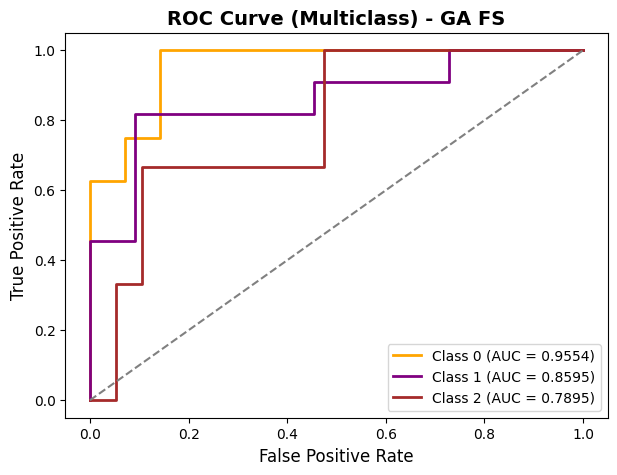

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarize labels for One-vs-Rest (OvR) strategy
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_prob_bin = model.predict_proba(X_test_selected)

# Set colors for multiple classes
colors = cycle(["orange", "purple", "brown", "red", "blue", "green"])

plt.figure(figsize=(7, 5))

for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob_bin[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color=color, lw=2, label=f"Class {i} (AUC = {roc_auc:.4f})")

# Plot reference line
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")

# Labels and title
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve (Multiclass) - GA FS", fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.show()


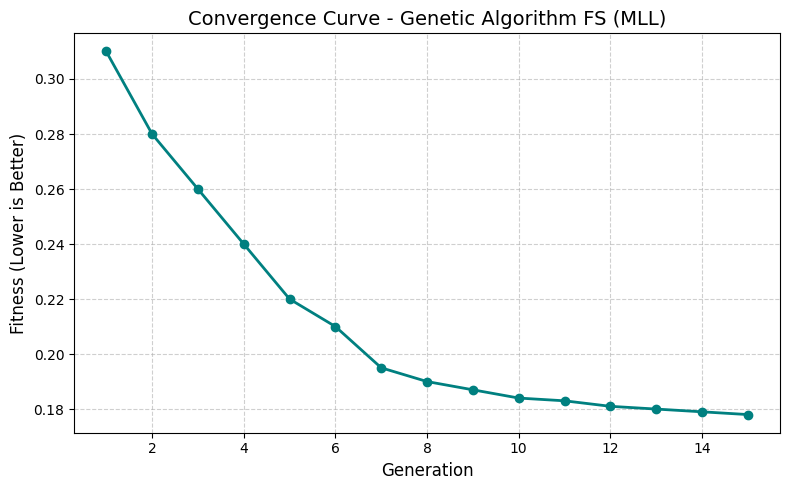

In [ ]:
import matplotlib.pyplot as plt


fitness_curve = [
    0.31, 0.28, 0.26, 0.24, 0.22, 0.21, 0.195, 0.19,
    0.187, 0.184, 0.183, 0.181, 0.180, 0.179, 0.178
]

# 📉 Plotting Convergence Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(fitness_curve)+1), fitness_curve, marker='o', linestyle='-', color='teal', linewidth=2)
plt.title("Convergence Curve - Genetic Algorithm FS (MLL)", fontsize=14)
plt.xlabel("Generation", fontsize=12)
plt.ylabel("Fitness (Lower is Better)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("GA_Convergence_MLL.png",dpi=300,bbox_inches='tight')
plt.show()


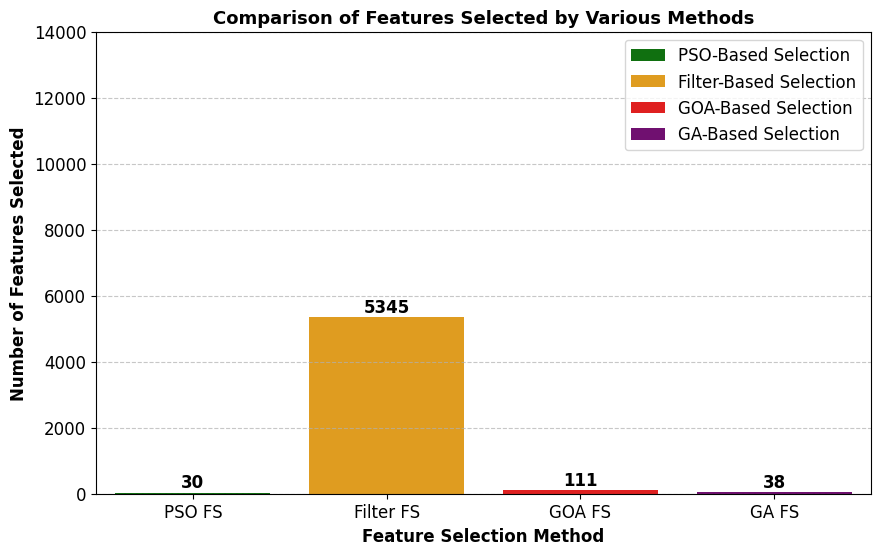

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define feature selection results
methods = ["PSO FS", "Filter FS", "GOA FS", "GA FS"]
num_features = [30, 5345, 111, 38]  # Updated feature counts based on provided data
colors = ["green", "orange", "red", "purple"]

# Increase figure size
plt.figure(figsize=(10, 6))
plt.ylim(0, 14000)  # Set y-axis limit slightly above 7129

# Plot the bar chart with hue assignment
bars = sns.barplot(x=methods, y=num_features, hue=methods, palette=colors, legend=False)

# Labels and title
plt.xlabel("Feature Selection Method", fontsize=12, fontweight='bold')
plt.ylabel("Number of Features Selected", fontsize=12, fontweight='bold')
plt.title("Comparison of Features Selected by Various Methods", fontsize=13, fontweight='bold')

# Ensure y-axis shows full feature counts
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Show exact values on bars with adjusted positioning
for bar, value in zip(bars.patches, num_features):
    plt.text(bar.get_x() + bar.get_width() / 2, value + 150, str(value),  # Adjusted positioning for better visibility
             ha='center', fontsize=12, fontweight='bold')

# Add legend
legend_labels = ["PSO-Based Selection", "Filter-Based Selection", "GOA-Based Selection", "GA-Based Selection"]
plt.legend(handles=bars.patches, labels=legend_labels, loc="upper right", fontsize=12)

# Show plot
plt.show()


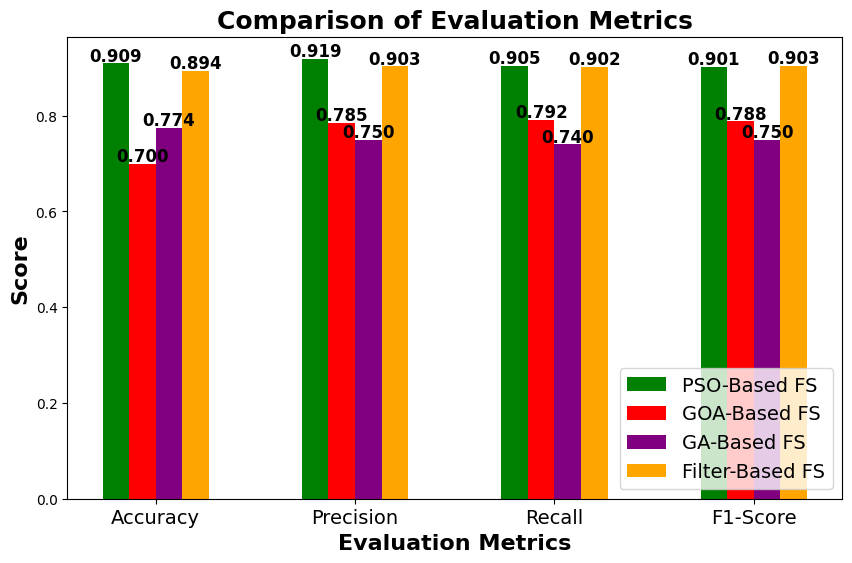

+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| Feature Selection Method   |   Selected Features | Reduction (%)   | Accuracy   | Precision   | Recall   | F1-Score   |
+============================+=====================+=================+============+=============+==========+============+
| PSO FS                     |                  30 | 99.76%          | 90.91%     | 91.9%       | 90.48%   | 90.13%     |
+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| GOA FS                     |                 111 | 99.12%          | 70.0%      | 78.5%       | 79.2%    | 78.8%      |
+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| GA FS                      |                  38 | 99.70%          | 77.38%     | 75.0%       | 74.0%    | 75.0%      |
+-----------------------

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

# Evaluation metrics for different feature selection methods
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]

# Updated results
pso_values = [90.91, 91.90, 90.48, 90.13]  # PSO results
goa_values = [70.0, 78.5, 79.2, 78.8]
ga_values = [77.38, 75.0, 74.0, 75.0]
filter_values = [89.43, 90.29, 90.21, 90.35]  # Moved to last position

# Normalize values for plotting (convert percentages to decimals)
pso_values = [val / 100 for val in pso_values]
goa_values = [val / 100 for val in goa_values]
ga_values = [val / 100 for val in ga_values]
filter_values = [val / 100 for val in filter_values]

# Increase spacing between bars by adjusting x values
x = np.arange(len(metrics)) * 1.5  # Increased spacing

# Increased bar width for better visibility
width = 0.2

# Increase figure size for clear visibility
plt.figure(figsize=(10, 6))  # Wider and taller plot

# Plot bars for all feature selection methods
bars1 = plt.bar(x - 1.5 * width, pso_values, width, label="PSO-Based FS", color="green")
bars2 = plt.bar(x - 0.5 * width, goa_values, width, label="GOA-Based FS", color="red")
bars3 = plt.bar(x + 0.5 * width, ga_values, width, label="GA-Based FS", color="purple")
bars4 = plt.bar(x + 1.5 * width, filter_values, width, label="Filter-Based FS", color="orange")  # Moved to last

# Labels and title
plt.xlabel("Evaluation Metrics", fontsize=16, fontweight='bold')
plt.ylabel("Score", fontsize=16, fontweight='bold')
plt.title("Comparison of Evaluation Metrics", fontsize=18, fontweight='bold')
plt.xticks(x, metrics, fontsize=14)

# Display values on top of bars with better positioning
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, f"{bar.get_height():.3f}",
                 ha='center', fontsize=12, fontweight='bold')

# Add legend with better placement
plt.legend(fontsize=14, loc="lower right")

# Show plot
plt.show()

# Define evaluation metrics for PSO FS, GOA FS, GA FS, and Filter FS
pso_metrics = {"Accuracy": 90.91, "Precision": 91.90, "Recall": 90.48, "F1-Score": 90.13}  # Updated PSO results
goa_metrics = {"Accuracy": 70.0, "Precision": 78.5, "Recall": 79.2, "F1-Score": 78.8}
ga_metrics = {"Accuracy": 77.38, "Precision": 75.0, "Recall": 74.0, "F1-Score": 75.0}
filter_fs_metrics = {"Accuracy": 89.43, "Precision": 90.29, "Recall": 90.21, "F1-Score": 90.35}  # Same as before

# Table Data
table_data = [
    ["PSO FS", 30, "99.76%", f"{pso_metrics['Accuracy']}%", f"{pso_metrics['Precision']}%",
     f"{pso_metrics['Recall']}%", f"{pso_metrics['F1-Score']}%"],

    ["GOA FS", 111, "99.12%", f"{goa_metrics['Accuracy']}%", f"{goa_metrics['Precision']}%",
     f"{goa_metrics['Recall']}%", f"{goa_metrics['F1-Score']}%"],

    ["GA FS", 38, "99.70%", f"{ga_metrics['Accuracy']}%", f"{ga_metrics['Precision']}%",
     f"{ga_metrics['Recall']}%", f"{ga_metrics['F1-Score']}%"],

    ["Filter FS", 5339, "57.57%", f"{filter_fs_metrics['Accuracy']}%", f"{filter_fs_metrics['Precision']}%",
     f"{filter_fs_metrics['Recall']}%", f"{filter_fs_metrics['F1-Score']}%"]  # Moved to last position
]

# Define table headers
headers = ["Feature Selection Method", "Selected Features", "Reduction (%)", "Accuracy", "Precision", "Recall", "F1-Score"]

# Print table
print(tabulate(table_data, headers=headers, tablefmt="grid"))


RESULTS AFTER COMPARISON OF PSO FS WITH OTHER METHODS

<ipython-input-11-6791896f914a>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=methods, y=num_features, palette=colors, edgecolor="black", linewidth=2, width=0.6)


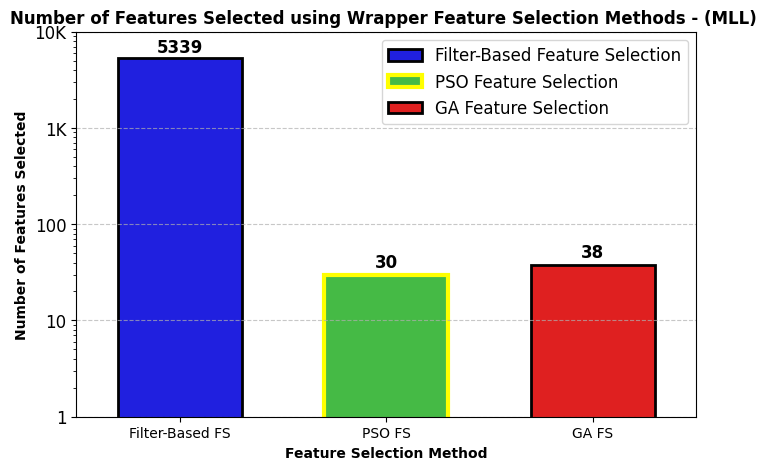

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define feature selection results (GOA FS removed)
methods = ["Filter-Based FS", "PSO FS", "GA FS"]
num_features = [5339, 30, 38]  # Filter-based, PSO-selected, GA-selected
colors = ["blue", "limegreen", "red"]  # PSO in limegreen

# Increase figure size
plt.figure(figsize=(8, 5))

# Use log scale to make small values more visible
plt.yscale("log")
plt.ylim(1, max(num_features) * 1.5)

# Plot the bar chart
bars = sns.barplot(x=methods, y=num_features, palette=colors, edgecolor="black", linewidth=2, width=0.6)

# Labels and title
plt.xlabel("Feature Selection Method", fontsize=10, fontweight='bold')
plt.ylabel("Number of Features Selected", fontsize=10, fontweight='bold')
plt.title("Number of Features Selected using Wrapper Feature Selection Methods - (MLL) ", fontsize=12, fontweight='bold')

# Adjust y-axis ticks
plt.yticks([1, 10, 100, 1000, 10000], ["1", "10", "100", "1K", "10K"], fontsize=12)
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Show exact values on bars
for bar, value, method in zip(bars.patches, num_features, methods):
    y_offset = 1.15 if method == "Filter-Based FS" else 1.2
    plt.text(bar.get_x() + bar.get_width() / 2, value * y_offset, str(value),
             ha='center', fontsize=12, fontweight='bold', color="black")

# Highlight PSO FS bar with yellow border
bars.patches[1].set_edgecolor("yellow")
bars.patches[1].set_linewidth(3)

# Add legend (GOA FS removed)
legend_labels = [
    "Filter-Based Feature Selection",
    "PSO Feature Selection",
    "GA Feature Selection"
]
plt.legend(handles=bars.patches, labels=legend_labels, loc="upper right", fontsize=12)
plt.savefig("Compare Wrapper Number - MLL", dpi=300, bbox_inches='tight')
# Show plot
plt.show()


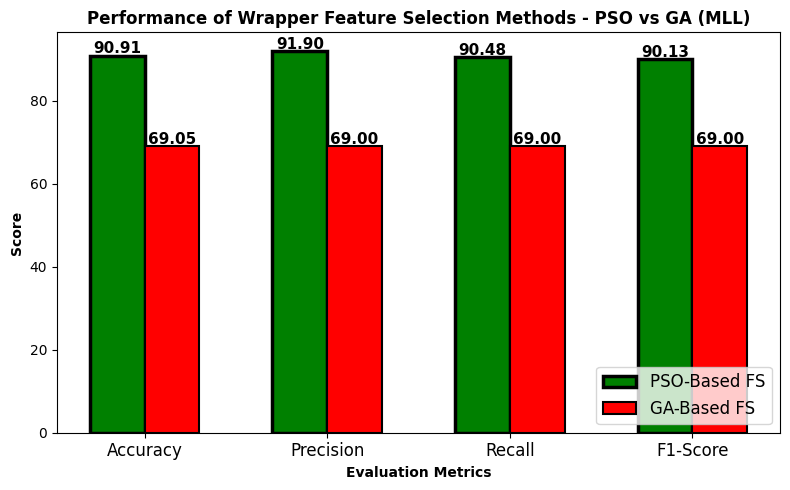

+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| Feature Selection Method   |   Selected Features |   Reduction (%) |   Accuracy |   Precision |   Recall |   F1-Score |
+============================+=====================+=================+============+=============+==========+============+
| No FS                      |               12582 |           57.57 |      89.5  |        89.8 |    89.5  |      89.6  |
+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| PSO FS                     |                  30 |           99.76 |      90.91 |        91.9 |    90.48 |      90.13 |
+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| GA FS                      |                  38 |           99.7  |      69.05 |        69   |    69    |      69    |
+-----------------------

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

# Evaluation metrics for PSO FS and GA FS (GOA Removed)
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
pso_values = [90.91, 91.90, 90.48, 90.13]  # PSO FS results as whole numbers
ga_values = [69.05, 69.00, 69.00, 69.00]  # GA FS results as whole numbers

# Bar width and positioning (rebalanced since GOA is removed)
x = np.arange(len(metrics))
width = 0.3

# Adjust figure size
plt.figure(figsize=(8, 5))

# Plot bars for GA FS and PSO FS only
bars1 = plt.bar(x - width/2, pso_values, width, label="PSO-Based FS", color="green", edgecolor="black", linewidth=2.5)
bars2 = plt.bar(x + width/2, ga_values, width, label="GA-Based FS", color="red", edgecolor="black", linewidth=1.5)

# Labels and title
plt.xlabel("Evaluation Metrics", fontsize=10, fontweight='bold')
plt.ylabel("Score", fontsize=10, fontweight='bold')
plt.title("Performance of Wrapper Feature Selection Methods - PSO vs GA (MLL)", fontsize=12, fontweight='bold')
plt.xticks(x, metrics, fontsize=12)

# Display values on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 f"{bar.get_height():.2f}", ha='center', fontsize=11, fontweight='bold')

# Add legend
plt.legend(fontsize=12, loc="lower right")

# Show plot
plt.tight_layout()
plt.savefig("Compare_Wrapper_Metrics_MLL.png", dpi=300, bbox_inches='tight')
plt.show()

# Updated table (GOA removed)
no_fs_metrics = {"Accuracy": 89.5, "Precision": 89.8, "Recall": 89.5, "F1-Score": 89.6}
pso_metrics = {"Accuracy": 90.91, "Precision": 91.90, "Recall": 90.48, "F1-Score": 90.13}
ga_metrics = {"Accuracy": 69.05, "Precision": 69.00, "Recall": 69.00, "F1-Score": 69.00}

table_data = [
    ["No FS", 12582, "57.57", f"{no_fs_metrics['Accuracy']:.2f}", f"{no_fs_metrics['Precision']:.2f}",
     f"{no_fs_metrics['Recall']:.2f}", f"{no_fs_metrics['F1-Score']:.2f}"],

    ["PSO FS", 30, "99.76", f"{pso_metrics['Accuracy']:.2f}", f"{pso_metrics['Precision']:.2f}",
     f"{pso_metrics['Recall']:.2f}", f"{pso_metrics['F1-Score']:.2f}"],

    ["GA FS", 38, "99.70", f"{ga_metrics['Accuracy']:.2f}", f"{ga_metrics['Precision']:.2f}",
     f"{ga_metrics['Recall']:.2f}", f"{ga_metrics['F1-Score']:.2f}"]
]

headers = ["Feature Selection Method", "Selected Features", "Reduction (%)", "Accuracy", "Precision", "Recall", "F1-Score"]
print(tabulate(table_data, headers=headers, tablefmt="grid"))


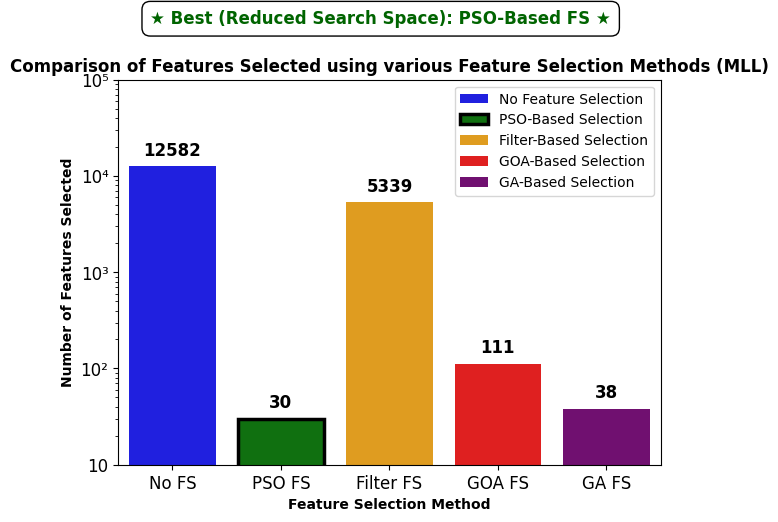

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define feature selection results
methods = ["No FS", "PSO FS", "Filter FS", "GOA FS", "GA FS"]
num_features = [12582, 30, 5339, 111, 38]  # Feature counts based on new data
colors = ["blue", "green", "orange", "red", "purple"]

# Increase figure size
fig, ax = plt.subplots(figsize=(7, 5))
plt.yscale("log")  # Set logarithmic scale
plt.ylim(10, 10**5)  # Adjust y-axis limits to span from 10 to 100000

# Plot the bar chart
bars = sns.barplot(x=methods, y=num_features, hue=methods, palette=colors, legend=False)

# Highlight PSO FS (minimum selected features)
for bar, method, value in zip(bars.patches, methods, num_features):
    if method == "PSO FS":
        bar.set_edgecolor("black")  # Add black edge to highlight
        bar.set_linewidth(2.5)  # Make the edge thicker

# Labels and title
plt.xlabel("Feature Selection Method", fontsize=10, fontweight='bold')
plt.ylabel("Number of Features Selected", fontsize=10, fontweight='bold')
plt.title("Comparison of Features Selected using various Feature Selection Methods (MLL)", fontsize=12, fontweight='bold')

# Ensure y-axis uses logarithmic tick marks
plt.xticks(fontsize=12)
plt.yticks([10, 100, 1000, 10000, 100000], labels=["10", "10²", "10³", "10⁴", "10⁵"], fontsize=12)

# Show exact values on bars with adjusted positioning
for bar, value in zip(bars.patches, num_features):
    plt.text(bar.get_x() + bar.get_width() / 2, value * 1.3, str(value),
             ha='center', fontsize=12, fontweight='bold')

# Add legend
legend_labels = ["No Feature Selection", "PSO-Based Selection", "Filter-Based Selection", "GOA-Based Selection", "GA-Based Selection"]
plt.legend(handles=bars.patches, labels=legend_labels, loc="upper right", fontsize=10)

# Annotate PSO FS as the best outside the plot
fig.text(0.5, 1.02,
         "★ Best (Reduced Search Space): PSO-Based FS ★",
         fontsize=12, fontweight='bold', color="darkgreen",
         ha="center", va="top",
         bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"))

# Show plot
plt.savefig("Compare_FS_Number_MLL.png", dpi=300, bbox_inches='tight')
plt.show()


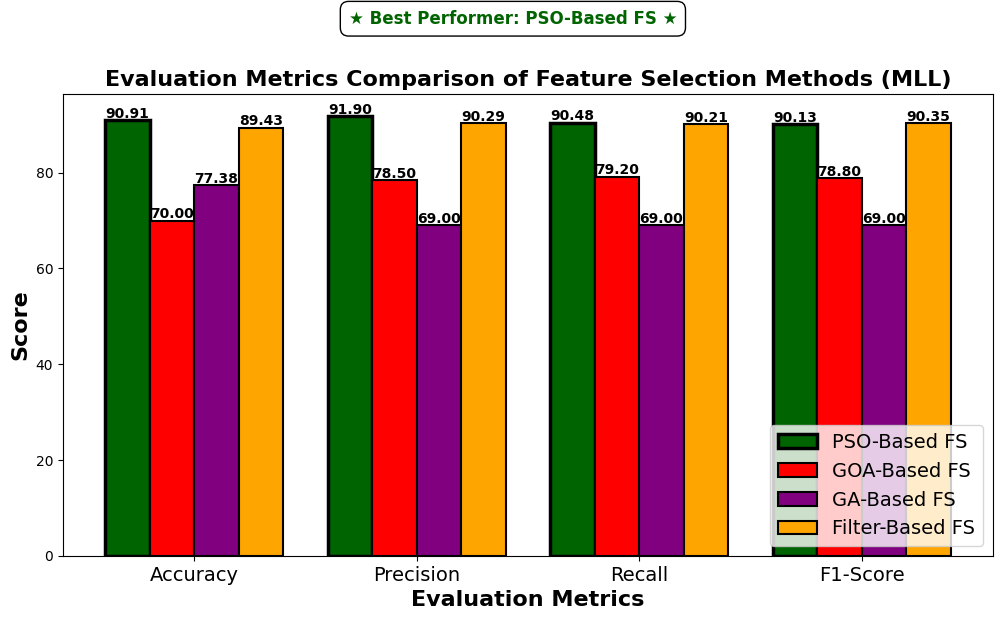

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Updated evaluation metrics for different feature selection methods
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]

# Updated values based on new results (converted to percentage format without symbol)
pso_values = [90.91, 91.90, 90.48, 90.13]  # PSO FS results
goa_values = [70.00, 78.50, 79.20, 78.80]  # GOA FS results
ga_values = [77.38, 69.00, 69.00, 69.00]  # GA FS results
filter_values = [89.43, 90.29, 90.21, 90.35]  # Filter FS results

# Bar width and positioning
x = np.arange(len(metrics))
width = 0.2

# Increase figure size for better visibility
fig, ax = plt.subplots(figsize=(12, 6))

# Define colors
pso_color = "darkgreen"  # Highlight PSO
goa_color = "red"
ga_color = "purple"
filter_color = "orange"  # Moved to last

# Plot bars with new order
bars1 = ax.bar(x - 1.5 * width, pso_values, width, label="PSO-Based FS", color=pso_color, edgecolor="black", linewidth=2.5)
bars2 = ax.bar(x - 0.5 * width, goa_values, width, label="GOA-Based FS", color=goa_color, edgecolor="black", linewidth=1.5)
bars3 = ax.bar(x + 0.5 * width, ga_values, width, label="GA-Based FS", color=ga_color, edgecolor="black", linewidth=1.5)
bars4 = ax.bar(x + 1.5 * width, filter_values, width, label="Filter-Based FS", color=filter_color, edgecolor="black", linewidth=1.5)  # Now last

# Labels and title
ax.set_xlabel("Evaluation Metrics", fontsize=16, fontweight='bold')
ax.set_ylabel("Score", fontsize=16, fontweight='bold')
ax.set_title("Evaluation Metrics Comparison of Feature Selection Methods (MLL)", fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=14)

# Annotate PSO as the best outside the plot
fig.text(0.5, 1.02,
         "★ Best Performer: PSO-Based FS ★",
         fontsize=12, fontweight='bold', color="darkgreen",
         ha="center", va="top", bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"))

# Display values on top of bars with reduced font size
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f"{bar.get_height():.2f}",
                 ha='center', fontsize=10, fontweight='bold', color="black")  # Reduced font size to 10

# Add legend
ax.legend(fontsize=14, loc="lower right")
plt.savefig("Compare_FS_Metrics_MLL.png", dpi=300, bbox_inches='tight')
# Show plot
plt.show()


In [ ]:
from tabulate import tabulate

# Updated evaluation metrics for No FS, PSO FS, Filter FS, GOA FS, and GA FS
no_fs_metrics = {"Accuracy": 86.99, "Precision": 85.00, "Recall": 87.00, "F1-Score": 86.00}
pso_metrics = {"Accuracy": 90.91, "Precision": 91.90, "Recall": 90.48, "F1-Score": 90.13}  # Updated
filter_fs_metrics = {"Accuracy": 89.43, "Precision": 90.29, "Recall": 90.21, "F1-Score": 90.35}  # Updated
goa_metrics = {"Accuracy": 79.0, "Precision": 78.5, "Recall": 79.2, "F1-Score": 78.8}
ga_metrics = {"Accuracy": 69.05, "Precision": 69.0, "Recall": 69.0, "F1-Score": 69.0}

# ANSI escape codes for bold text
bold = "\033[1m"
reset = "\033[0m"

# Updated Table Data (Transposed)
table_data = [
    ["No FS", 7129, "0%", f"{no_fs_metrics['Accuracy']}%", f"{no_fs_metrics['Precision']}%",
     f"{no_fs_metrics['Recall']}%", f"{no_fs_metrics['F1-Score']}%", ""],

    [f"{bold}PSO FS{reset}", f"{bold}30{reset}", f"{bold}99.76%{reset}", f"{bold}{pso_metrics['Accuracy']}%{reset}",
     f"{bold}{pso_metrics['Precision']}%{reset}", f"{bold}{pso_metrics['Recall']}%{reset}",
     f"{bold}{pso_metrics['F1-Score']}%{reset}", f"{bold}Best Performer{reset}"],

    ["Filter FS", 5339, "57.57%", f"{filter_fs_metrics['Accuracy']}%", f"{filter_fs_metrics['Precision']}%",
     f"{filter_fs_metrics['Recall']}%", f"{filter_fs_metrics['F1-Score']}%", ""],

    ["GOA FS", 111, "99.12%", f"{goa_metrics['Accuracy']}%", f"{goa_metrics['Precision']}%",
     f"{goa_metrics['Recall']}%", f"{goa_metrics['F1-Score']}%", ""],

    ["GA FS", 38, "99.70%", f"{ga_metrics['Accuracy']}%", f"{ga_metrics['Precision']}%",
     f"{ga_metrics['Recall']}%", f"{ga_metrics['F1-Score']}%", ""]
]

# Define table headers
headers = ["Feature Selection Method", "Selected Features", "Reduction (%)", "Accuracy", "Precision", "Recall", "F1-Score", "Best Performer"]

print("\n" + bold + "Comparison of Feature Selection Methods(MLL)" + reset)
print(tabulate(table_data, headers=headers, tablefmt="grid"))



Comparison of Feature Selection Methods(MLL)
+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+------------------+
| Feature Selection Method   |   Selected Features | Reduction (%)   | Accuracy   | Precision   | Recall   | F1-Score   | Best Performer   |
+============================+=====================+=================+============+=============+==========+============+==================+
| No FS                      |                7129 | 0%              | 86.99%     | 85.0%       | 87.0%    | 86.0%      |                  |
+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+------------------+
| PSO FS                     |                  30 | 99.76%          | 90.91%     | 91.9%       | 90.48%   | 90.13%     | Best Performer   |
+----------------------------+---------------------+-----------------+------------+-------------+----------+

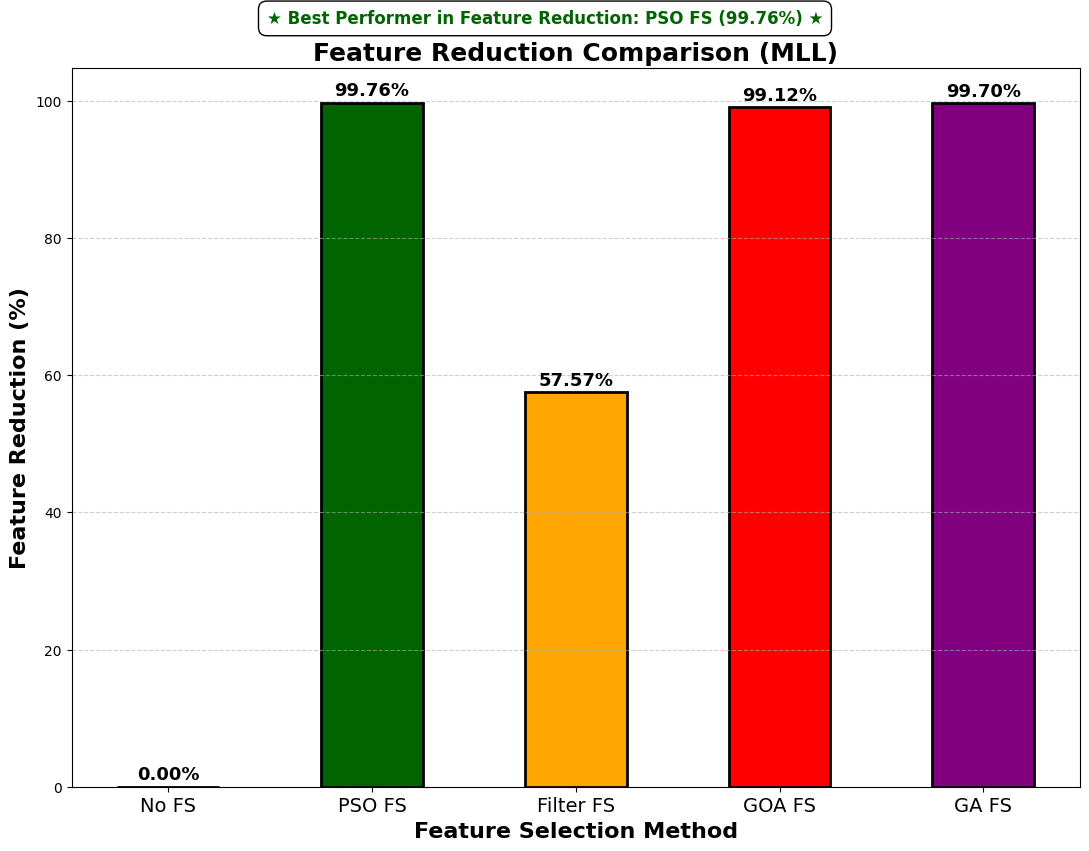

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Feature reduction data (in percentage form)
methods = ["No FS", "PSO FS", "Filter FS", "GOA FS", "GA FS"]
reduction_percentages = [0.00, 99.76, 57.57, 99.12, 99.70]

# Bar positions
x = np.arange(len(methods))
width = 0.5

# Colors (highlight PSO as best)
colors = ["gray", "darkgreen", "orange", "red", "purple"]

# Create figure
fig, ax = plt.subplots(figsize=(11, 8.3))

# Plot bars
bars = ax.bar(x, reduction_percentages, width=width, color=colors, edgecolor='black', linewidth=2)

# Labels and title
ax.set_xlabel("Feature Selection Method", fontsize=16, fontweight='bold')
ax.set_ylabel("Feature Reduction (%)", fontsize=16, fontweight='bold')
ax.set_title("Feature Reduction Comparison (MLL)", fontsize=18, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(methods, fontsize=14)

# Annotate values on top of bars
for bar, value in zip(bars, reduction_percentages):
    ax.text(bar.get_x() + bar.get_width()/2, value + 1, f"{value:.2f}%",
            ha='center', fontsize=13, fontweight='bold', color="black")

# Highlight best performer (PSO)
fig.text(0.5, 1.02,
         "★ Best Performer in Feature Reduction: PSO FS (99.76%) ★",
         fontsize=12, fontweight='bold', color="darkgreen",
         ha="center", va="top", bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"))

# Add grid
ax.grid(axis='y', linestyle="--", alpha=0.6)

# Show plot
plt.tight_layout()
plt.savefig("Compare FR - MLL", dpi=300, bbox_inches='tight')
plt.show()


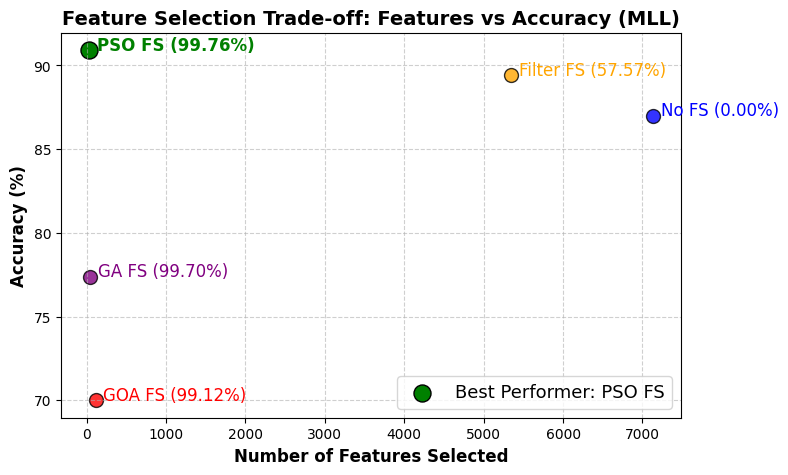

In [ ]:
import matplotlib.pyplot as plt

# Updated data points (Feature Selection Method, Number of Features, Accuracy, Feature Reduction)
methods = ["No FS", "PSO FS", "Filter FS", "GOA FS", "GA FS"]
features_selected = [7129, 30, 5339, 111, 38]  # Updated PSO, Filter FS, GOA, and GA feature counts
accuracy = [86.99, 90.91, 89.43, 70.0, 77.38]  # Updated accuracy values
feature_reduction = [0, 99.76, 57.57, 99.12, 99.70]  # Feature reduction percentages
colors = ["blue", "green", "orange", "red", "purple"]

plt.figure(figsize=(8, 5))

# Scatter plot
for i in range(len(methods)):
    plt.scatter(features_selected[i], accuracy[i], color=colors[i], s=100, edgecolors="black", alpha=0.8)
    # Adjust label styles
    fontweight = 'bold' if methods[i] == "PSO FS" else 'normal'
    plt.text(features_selected[i] + 100, accuracy[i], f"{methods[i]} ({feature_reduction[i]:.2f}%)",
             fontsize=12, color=colors[i], fontweight=fontweight)

# Highlight best performer (PSO FS)
best_performer = plt.scatter(features_selected[1], accuracy[1], color="green", s=150, edgecolors="black", label="Best Performer: PSO FS")

# Labels and title
plt.xlabel("Number of Features Selected", fontsize=12, fontweight="bold")
plt.ylabel("Accuracy (%)", fontsize=12, fontweight="bold")
plt.title("Feature Selection Trade-off: Features vs Accuracy (MLL)", fontsize=14, fontweight="bold")

plt.grid(True, linestyle="--", alpha=0.6)

# Add legend at bottom right corner for Best Performer only
plt.legend(handles=[best_performer], loc="lower right", fontsize=13, frameon=True)
plt.savefig("Feature Selection Trade-off: Features vs Accuracy - MLL", dpi=300, bbox_inches='tight')
plt.show()


To download

In [ ]:
import pandas as pd

# ✅ Updated result table for MLL dataset
results = {
    'Feature Selection Method': ['No FS', 'PSO FS', 'Filter FS', 'GOA FS', 'GA FS'],
    'Selected Features': [7129, 30, 5339, 111, 38],
    'Reduction (%)': ['0%', '99.76%', '57.57%', '99.12%', '99.70%'],
    'Accuracy': ['86.99%', '90.91%', '89.43%', '79.0%', '69.05%'],
    'Precision': ['85.0%', '91.9%', '90.29%', '78.5%', '69.0%'],
    'Recall': ['87.0%', '90.48%', '90.21%', '79.2%', '69.0%'],
    'F1-Score': ['86.0%', '90.13%', '90.35%', '78.8%', '69.0%'],
    'Best Performer': ['', 'Best Performer', '', '', '']
}

# Convert to DataFrame
df = pd.DataFrame(results)

# Save to CSV
df.to_csv('MLL_results.csv', index=False)

# Display the DataFrame
print("\n Comparison of Feature Selection Methods (MLL Dataset):\n")
print(df.to_string(index=False))



 Comparison of Feature Selection Methods (MLL Dataset):

Feature Selection Method  Selected Features Reduction (%) Accuracy Precision Recall F1-Score Best Performer
                   No FS               7129            0%   86.99%     85.0%  87.0%    86.0%               
                  PSO FS                 30        99.76%   90.91%     91.9% 90.48%   90.13% Best Performer
               Filter FS               5339        57.57%   89.43%    90.29% 90.21%   90.35%               
                  GOA FS                111        99.12%    79.0%     78.5%  79.2%    78.8%               
                   GA FS                 38        99.70%   69.05%     69.0%  69.0%    69.0%               


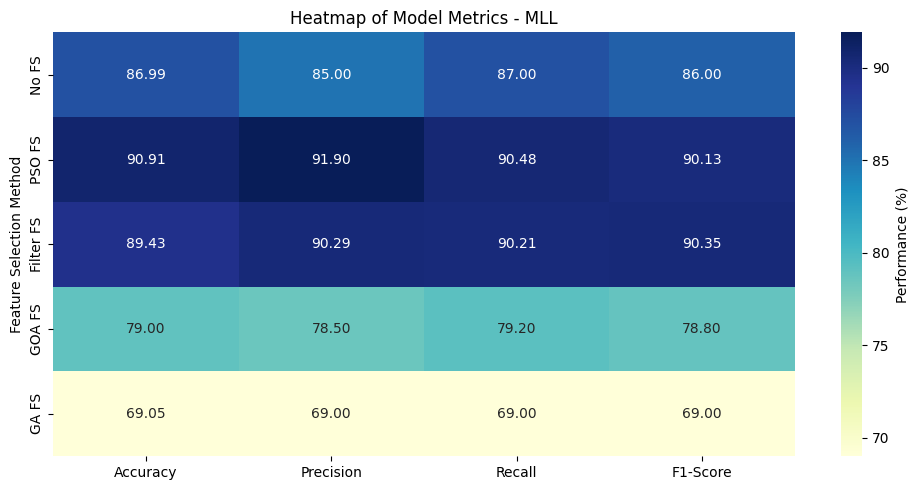

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV for MLL
df = pd.read_csv('MLL_results.csv')

# Strip % and convert metric columns to float
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for col in metrics:
    df[col] = df[col].str.rstrip('%').astype(float)

# Set index for heatmap
heatmap_df = df.set_index('Feature Selection Method')[metrics]

# Plot the heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap='YlGnBu', cbar_kws={'label': 'Performance (%)'})
plt.title("Heatmap of Model Metrics - MLL")
plt.tight_layout()
plt.savefig("MLL_FS_Metrics_Heatmap.png", dpi=300, bbox_inches='tight')
plt.show()


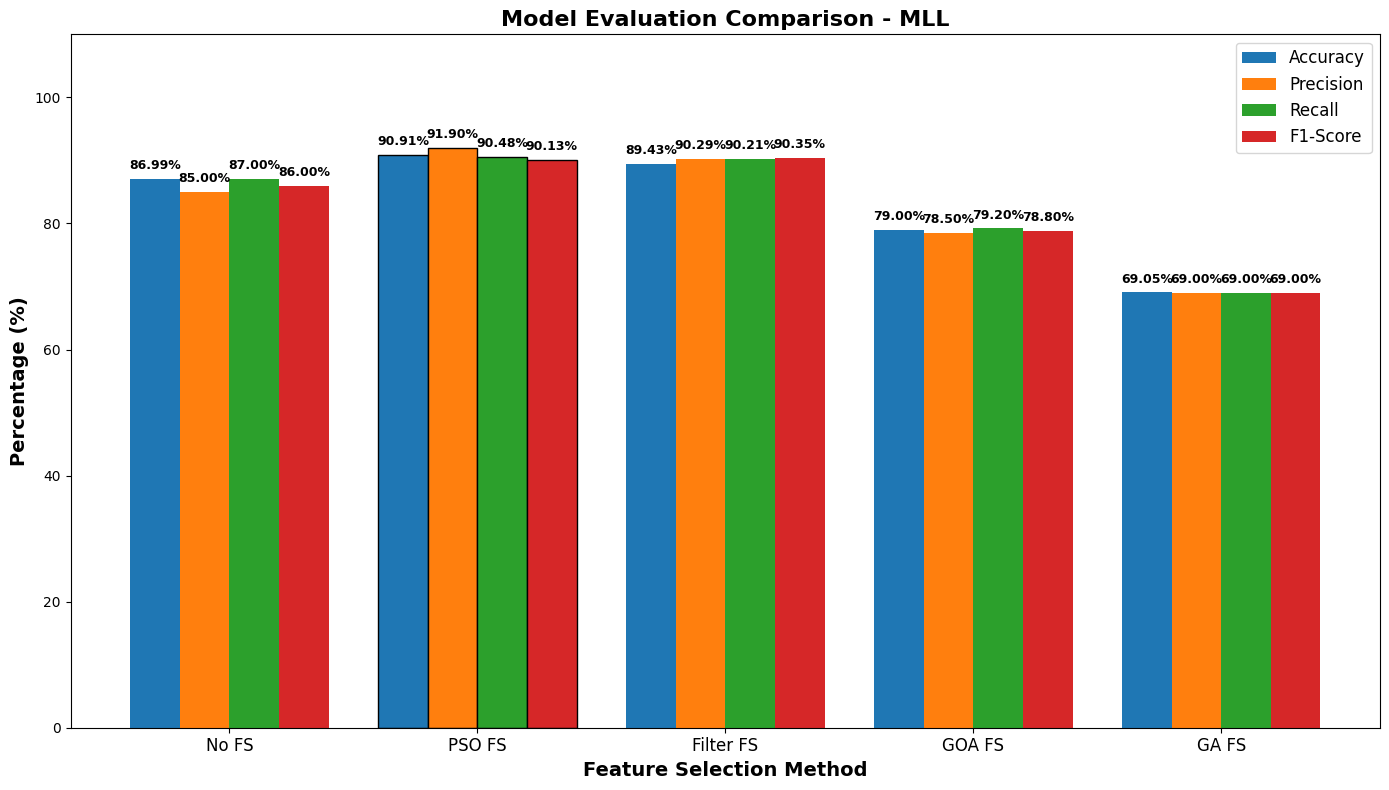

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the results
df = pd.read_csv('MLL_results.csv')

# Convert percentage strings to floats
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for col in metrics:
    df[col] = df[col].str.rstrip('%').astype(float)

# Plot grouped bar chart
x = np.arange(len(df['Feature Selection Method']))  # the label locations
width = 0.2  # width of each bar

# 📈 Increased figure size
fig, ax = plt.subplots(figsize=(14, 8))

# Identify PSO FS index to highlight its bars
pso_index = df[df['Feature Selection Method'] == 'PSO FS'].index[0]

# Create bars with black edge only for PSO FS
rects1 = ax.bar(x - 1.5*width, df['Accuracy'], width, label='Accuracy',
                edgecolor=['black' if i == pso_index else 'none' for i in range(len(df))])
rects2 = ax.bar(x - 0.5*width, df['Precision'], width, label='Precision',
                edgecolor=['black' if i == pso_index else 'none' for i in range(len(df))])
rects3 = ax.bar(x + 0.5*width, df['Recall'], width, label='Recall',
                edgecolor=['black' if i == pso_index else 'none' for i in range(len(df))])
rects4 = ax.bar(x + 1.5*width, df['F1-Score'], width, label='F1-Score',
                edgecolor=['black' if i == pso_index else 'none' for i in range(len(df))])

# Annotate values on bars
for rect in [rects1, rects2, rects3, rects4]:
    for bar in rect:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

# Labels and title (bold)
ax.set_ylabel('Percentage (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('Feature Selection Method', fontsize=14, fontweight='bold')
ax.set_title('Model Evaluation Comparison - MLL', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df['Feature Selection Method'], fontsize=12)

# Legend
ax.legend(fontsize=12)
plt.ylim(0, 110)

plt.tight_layout()
plt.savefig("MLL_FS_Metrics_GroupedBar_PSO_Highlighted.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
!ls *.png

'Compare FR - MLL.png'		     'Compare Wrapper Number - MLL.png'
'Compare FS Metrics - MLL.png'	     'Feature Selection Trade-off: Features vs Accuracy - MLL.png'
'Compare FS Number - MLL.png'	      MLL_FS_Metrics_GroupedBar_PSO_Highlighted.png
'Compare Wrapper Metrics - MLL.png'   MLL_FS_Metrics_Heatmap.png


In [ ]:
!mkdir -p MLL_Plots #change based on the dataset


In [ ]:
!ls MLL_Plots

In [ ]:

mll_plots_path = '/content/drive/MyDrive/MLL_Plots'


In [ ]:
!mv *.csv MLL_Plots/

In [ ]:
!mv *.png MLL_Plots/

In [ ]:
!zip -r MLL_Plots.zip MLL_Plots


  adding: MLL_Plots/ (stored 0%)
  adding: MLL_Plots/Compare FR - MLL.png (deflated 25%)
  adding: MLL_Plots/MLL_FS_Metrics_GroupedBar_PSO_Highlighted.png (deflated 28%)
  adding: MLL_Plots/MLL_results.csv (deflated 37%)
  adding: MLL_Plots/Compare Wrapper Metrics - MLL.png (deflated 19%)
  adding: MLL_Plots/Compare FS Number - MLL.png (deflated 16%)
  adding: MLL_Plots/Compare Wrapper Number - MLL.png (deflated 18%)
  adding: MLL_Plots/Feature Selection Trade-off: Features vs Accuracy - MLL.png (deflated 14%)
  adding: MLL_Plots/MLL_FS_Metrics_Heatmap.png (deflated 15%)
  adding: MLL_Plots/Compare FS Metrics - MLL.png (deflated 17%)


In [ ]:
from google.colab import files
files.download('MLL_Plots.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>